## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [162]:
!pip install pandas==1.5.3 numpy==1.25.2 matplotlib==3.7.1 seaborn==0.13.1 \
scikit-learn==1.2.2 imbalanced-learn==0.10.1 xgboost==2.0.3 threadpoolctl==3.3.0 -q --user

**Note:** After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.

In [163]:
#Reading and manipulating data
import pandas as pd
import numpy as np

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Missing value imputation
from sklearn.impute import SimpleImputer

# Model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# Metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    )

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

## Loading the dataset

In [164]:
# reading csv files into seperate pandas Dataframes
train = pd.read_csv('/content/Train (1).csv')
test = pd.read_csv('/content/Test (1).csv')

# print the shape of both Dataframes
print(train.shape)
print(test.shape)

# copying data to another varaible to preserve original training data
df_train = train.copy()
df_test = test.copy()

(20000, 41)
(5000, 41)


## Data Overview

- Observations
- Sanity checks

In [4]:
# View the first 5 rows of the dataset
df_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.46,-4.68,3.10,0.51,-0.22,-2.03,-2.91,0.05,-1.52,3.76,-5.71,0.74,0.98,1.42,-3.38,-3.05,0.31,2.91,2.27,4.39,-2.39,0.65,-1.19,3.13,0.67,-2.51,-0.04,0.73,-3.98,-1.07,1.67,3.06,-1.69,2.85,2.24,6.67,0.44,-2.37,2.95,-3.48,0
1,3.37,3.65,0.91,-1.37,0.33,2.36,0.73,-4.33,0.57,-0.10,1.91,-0.95,-1.26,-2.71,0.19,-4.77,-2.21,0.91,0.76,-5.83,-3.07,1.60,-1.76,1.77,-0.27,3.63,1.50,-0.59,0.78,-0.20,0.02,-1.80,3.03,-2.47,1.89,-2.30,-1.73,5.91,-0.39,0.62,0
2,-3.83,-5.82,0.63,-2.42,-1.77,1.02,-2.10,-3.17,-2.08,5.39,-0.77,1.11,1.14,0.94,-3.16,-4.25,-4.04,3.69,3.31,1.06,-2.14,1.65,-1.66,1.68,-0.45,-4.55,3.74,1.13,-2.03,0.84,-1.60,-0.26,0.80,4.09,2.29,5.36,0.35,2.94,3.84,-4.31,0
3,1.62,1.89,7.05,-1.15,0.08,-1.53,0.21,-2.49,0.34,2.12,-3.05,0.46,2.70,-0.64,-0.45,-3.17,-3.40,-1.28,1.58,-1.95,-3.52,-1.21,-5.63,-1.82,2.12,5.29,4.75,-2.31,-3.96,-6.03,4.95,-3.58,-2.58,1.36,0.62,5.55,-1.53,0.14,3.10,-1.28,0
4,-0.11,3.87,-3.76,-2.98,3.79,0.54,0.21,4.85,-1.85,-6.22,2.00,4.72,0.71,-1.99,-2.63,4.18,2.25,3.73,-6.31,-5.38,-0.89,2.06,9.45,4.49,-3.95,4.58,-8.78,-3.38,5.11,6.79,2.04,8.27,6.63,-10.07,1.22,-3.23,1.69,-2.16,-3.64,6.51,0


In [5]:
# Check data types and number of non-null values for each column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [6]:
df_train.shape

(20000, 41)

In [7]:
df_train.isnull().sum()

,0
V1,18
V2,18
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


In [8]:
# check for duplicates
df_train.duplicated().sum()

0

**Observations:**

* The columns 'V1' and 'V2' have missing values
* All of the columns are of datatype 'float64'. This is as expected, since the information from the sensors should be continuous data, both positive or negative.
* The dependent variable is of the datatype 'int64'. This is as expected, since the variable should be a binary 1 or 0, failure or no failure.

In [9]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.00,-0.27,3.44,-11.88,-2.74,-0.75,1.84,15.49
V2,19982.00,0.44,3.15,-12.32,-1.64,0.47,2.54,13.09
V3,20000.00,2.48,3.39,-10.71,0.21,2.26,4.57,17.09
V4,20000.00,-0.08,3.43,-15.08,-2.35,-0.14,2.13,13.24
V5,20000.00,-0.05,2.10,-8.60,-1.54,-0.10,1.34,8.13
V6,20000.00,-1.00,2.04,-10.23,-2.35,-1.00,0.38,6.98
V7,20000.00,-0.88,1.76,-7.95,-2.03,-0.92,0.22,8.01
V8,20000.00,-0.55,3.30,-15.66,-2.64,-0.39,1.72,11.68
V9,20000.00,-0.02,2.16,-8.60,-1.49,-0.07,1.41,8.14
V10,20000.00,-0.01,2.19,-9.85,-1.41,0.10,1.48,8.11


## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [10]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

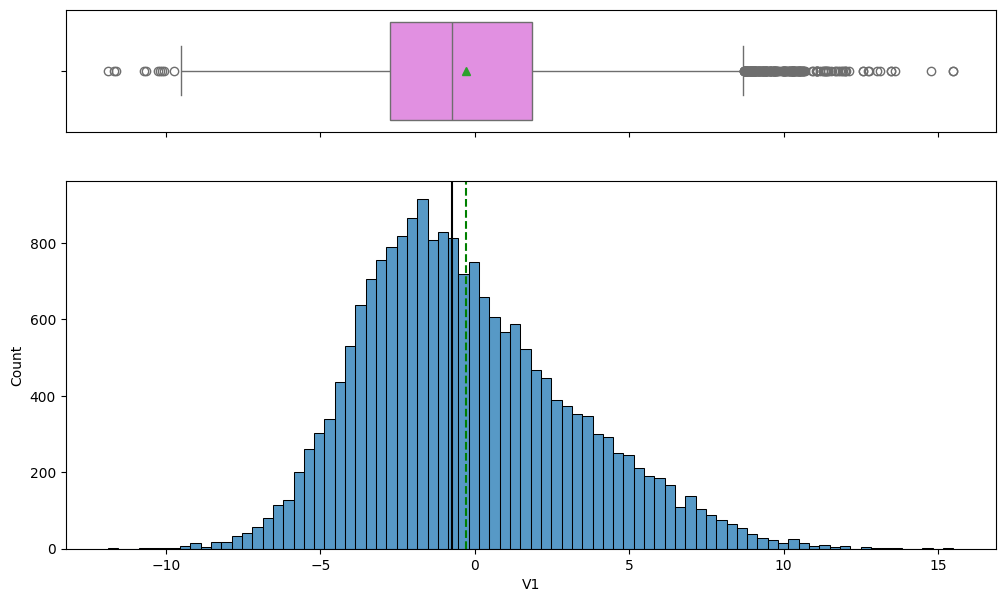

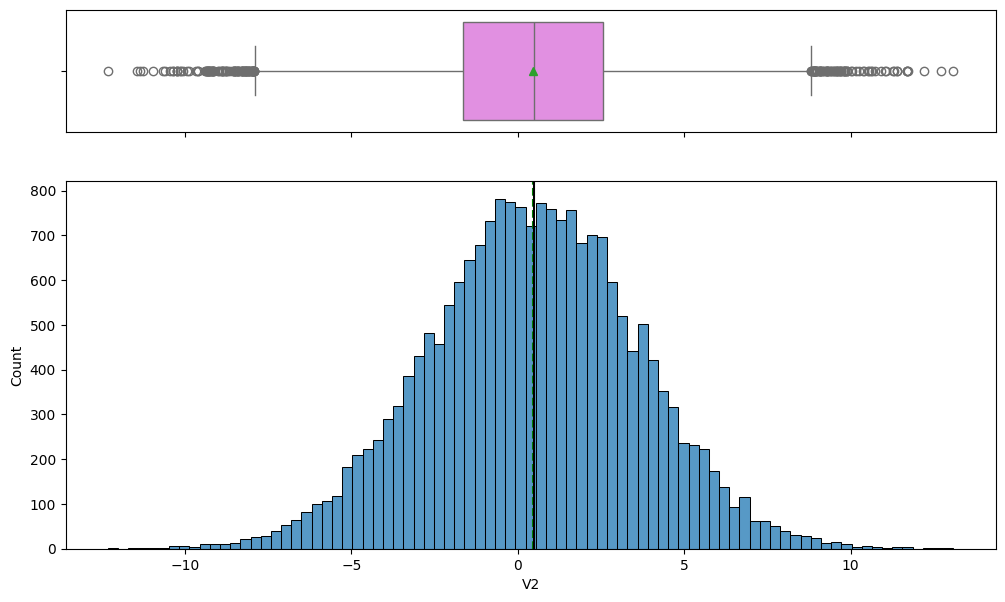

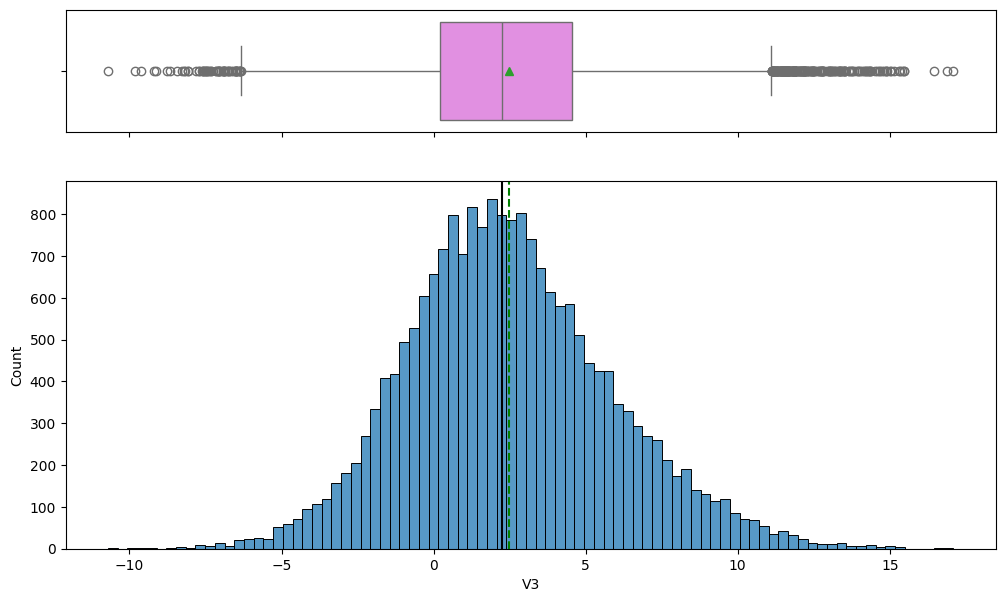

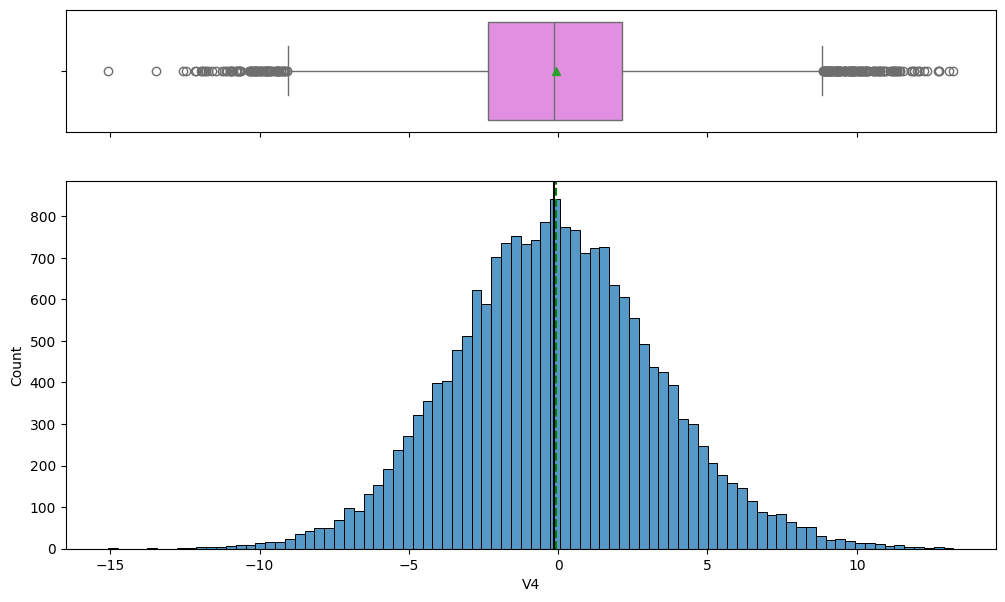

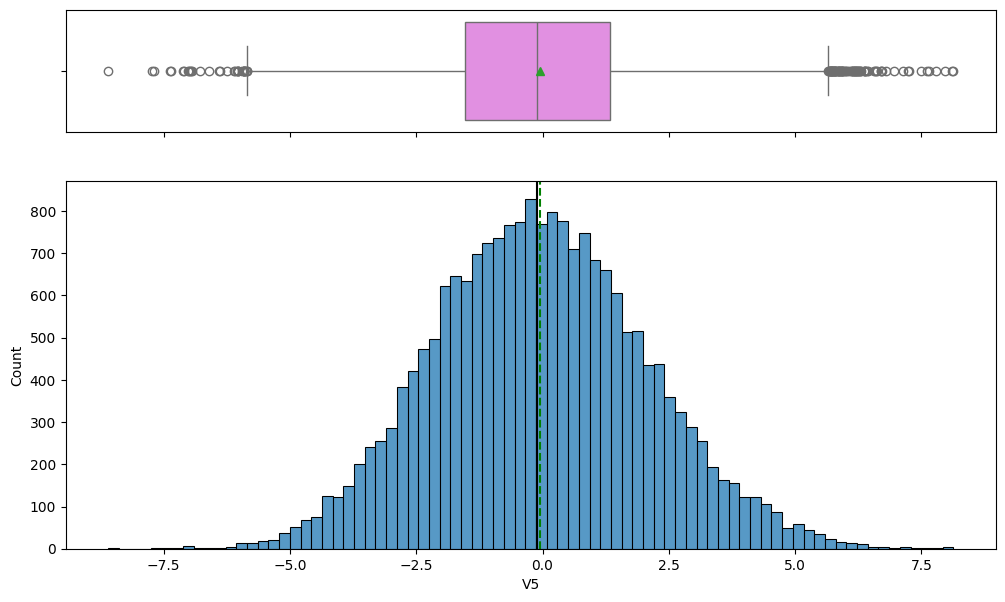

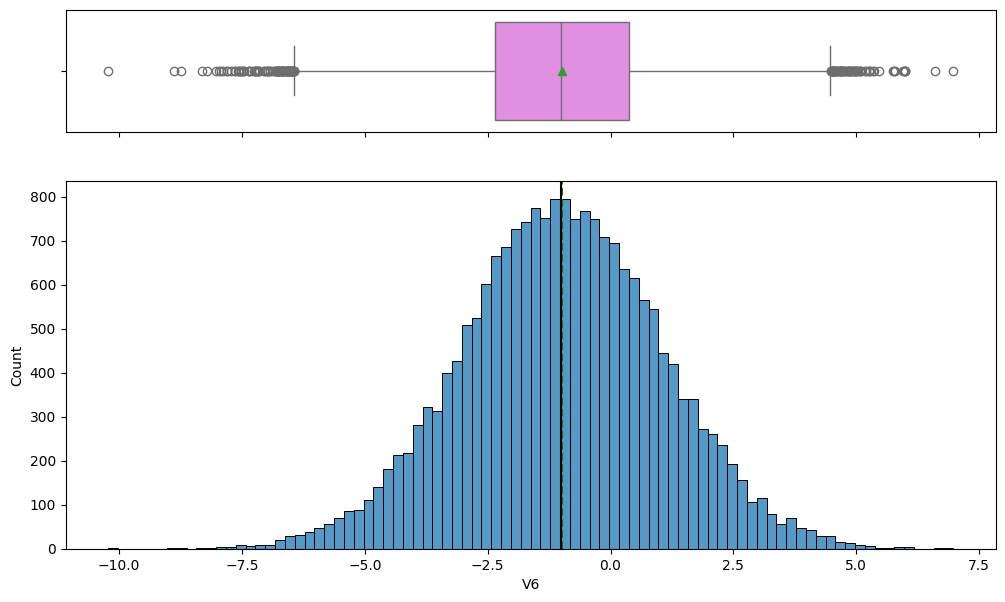

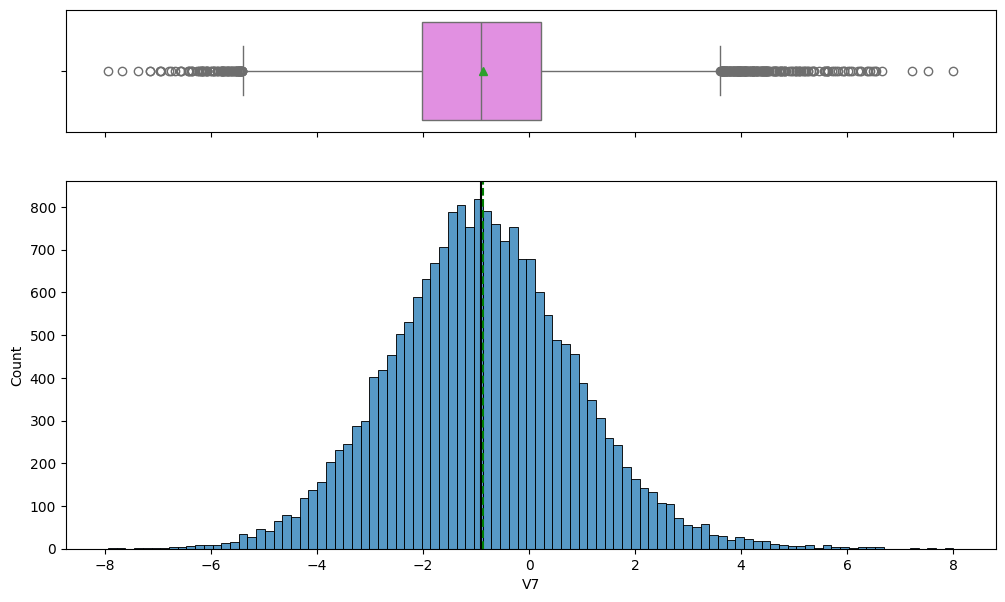

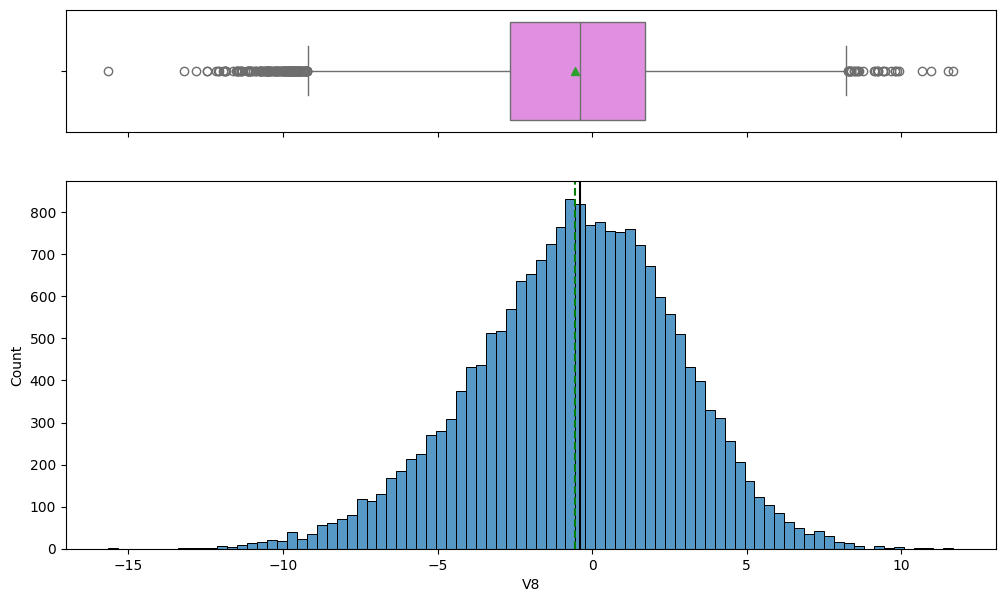

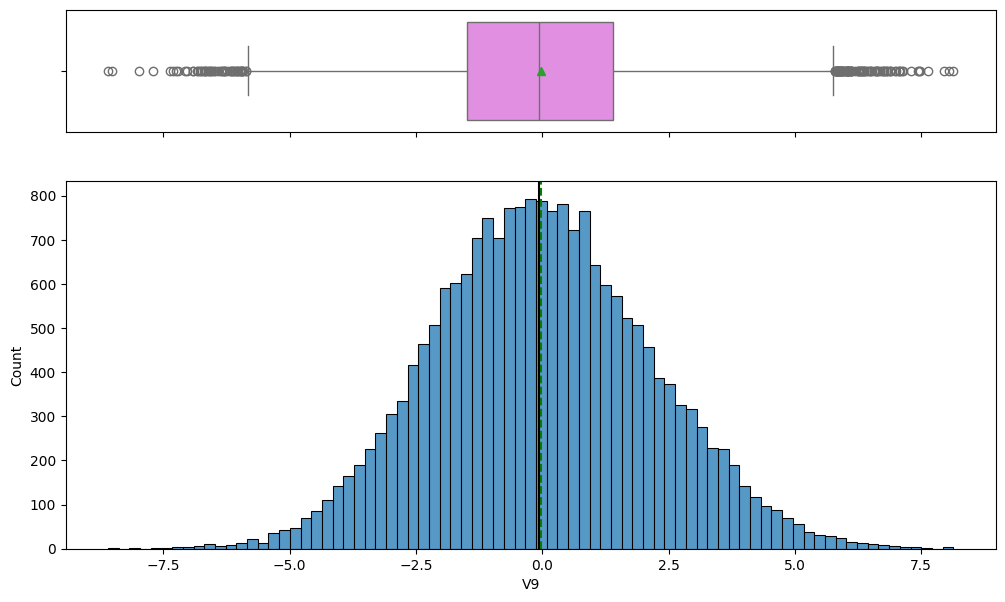

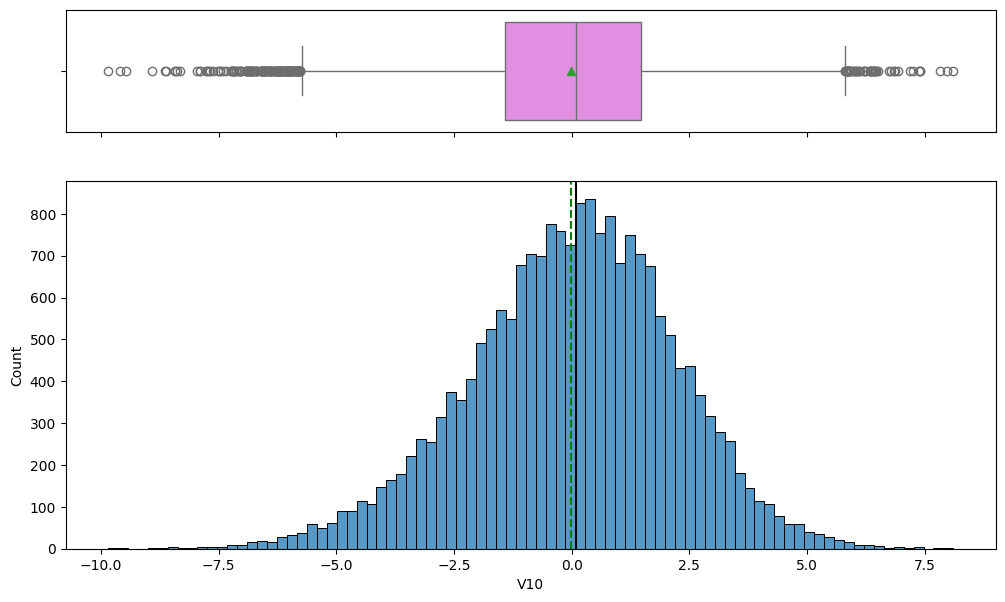

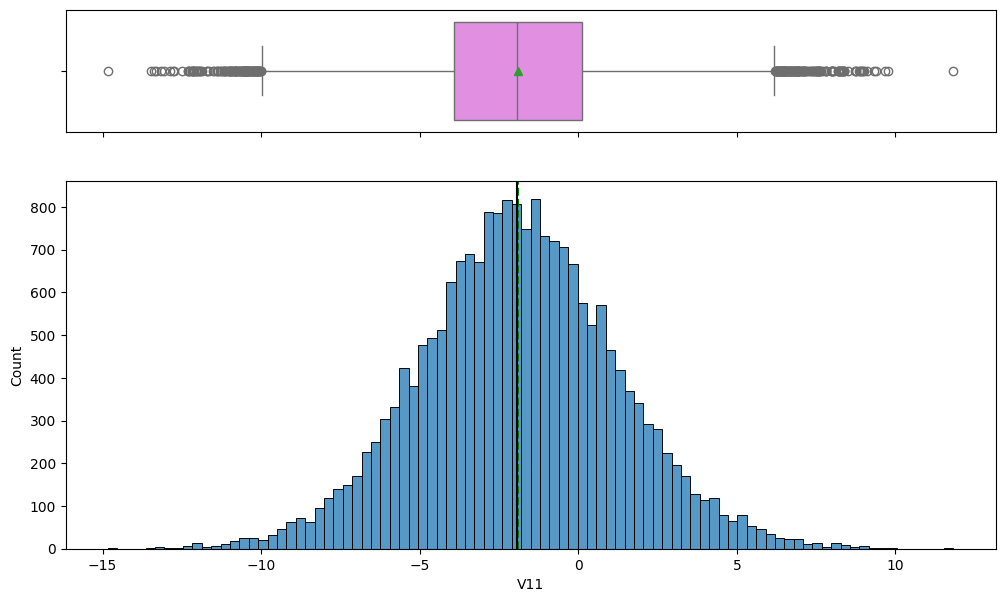

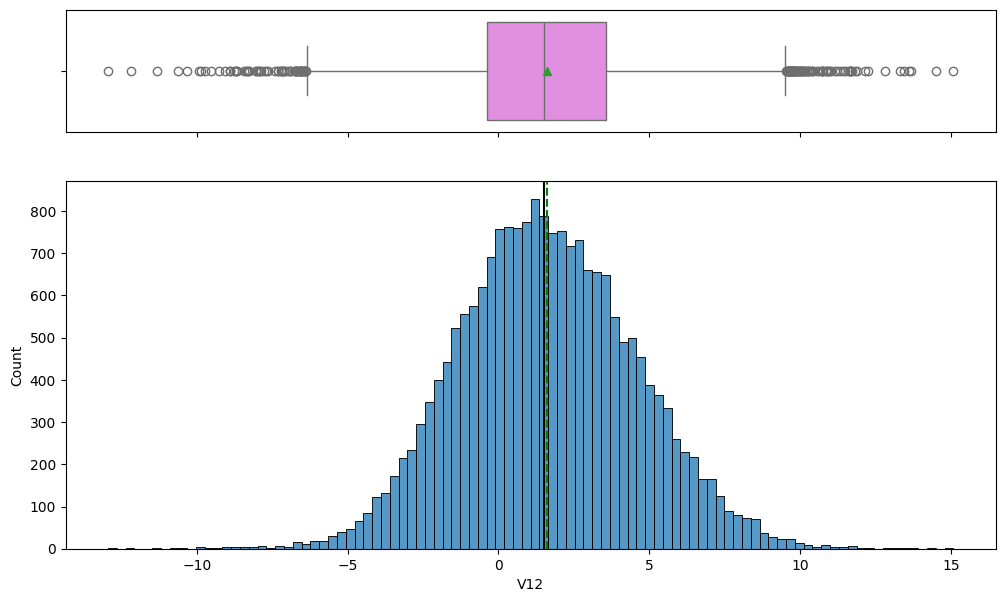

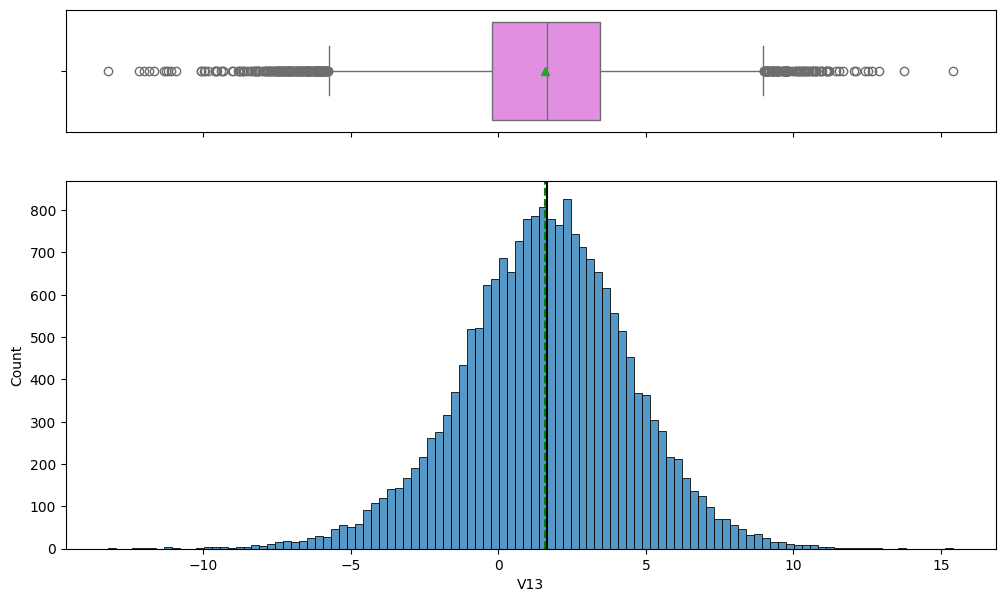

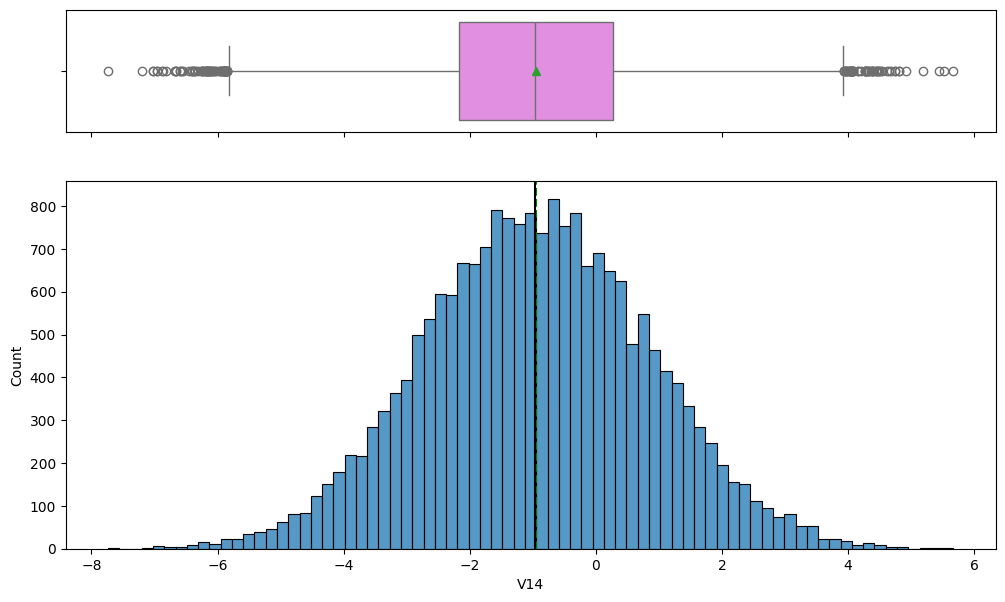

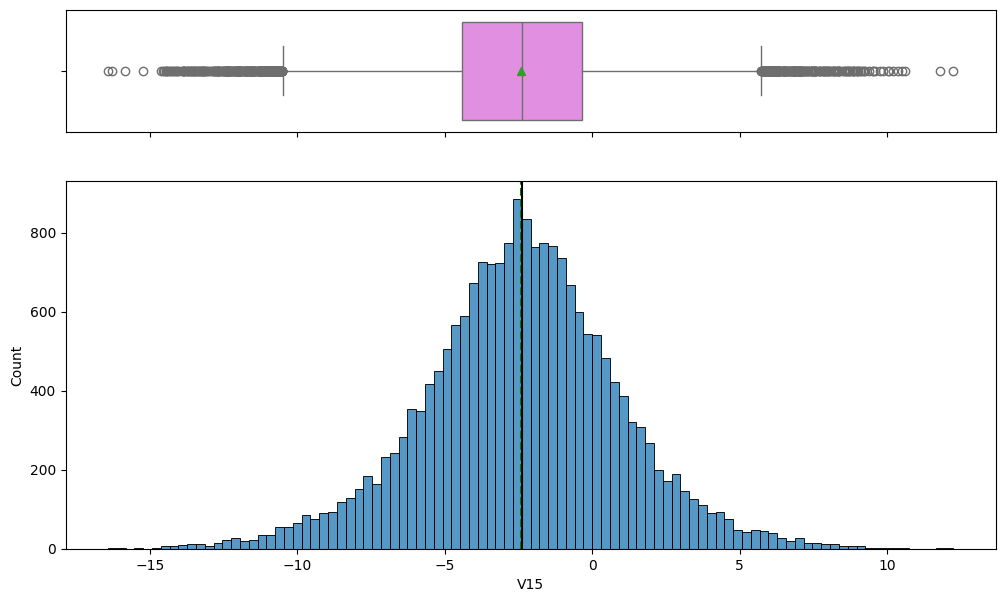

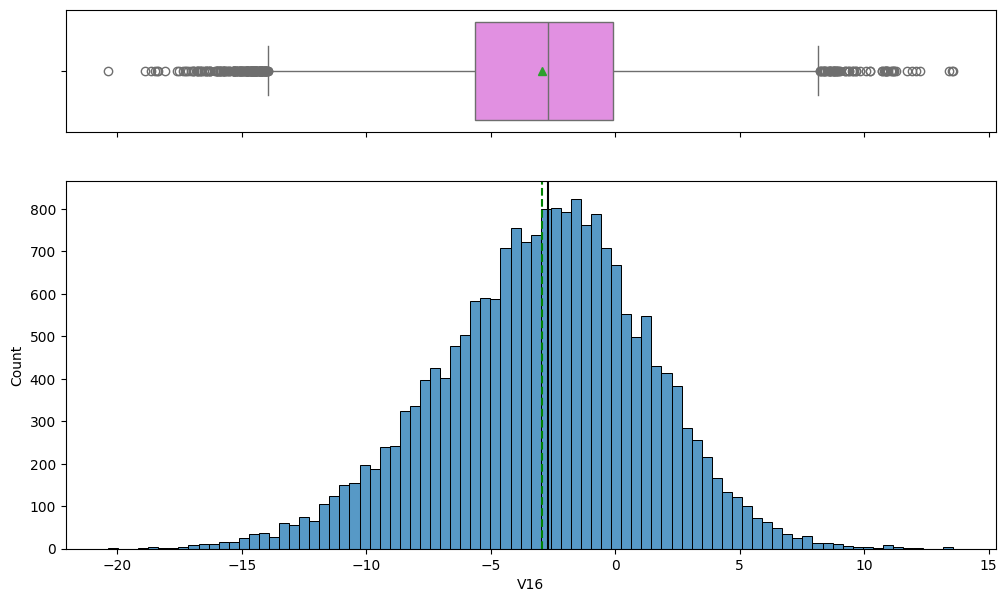

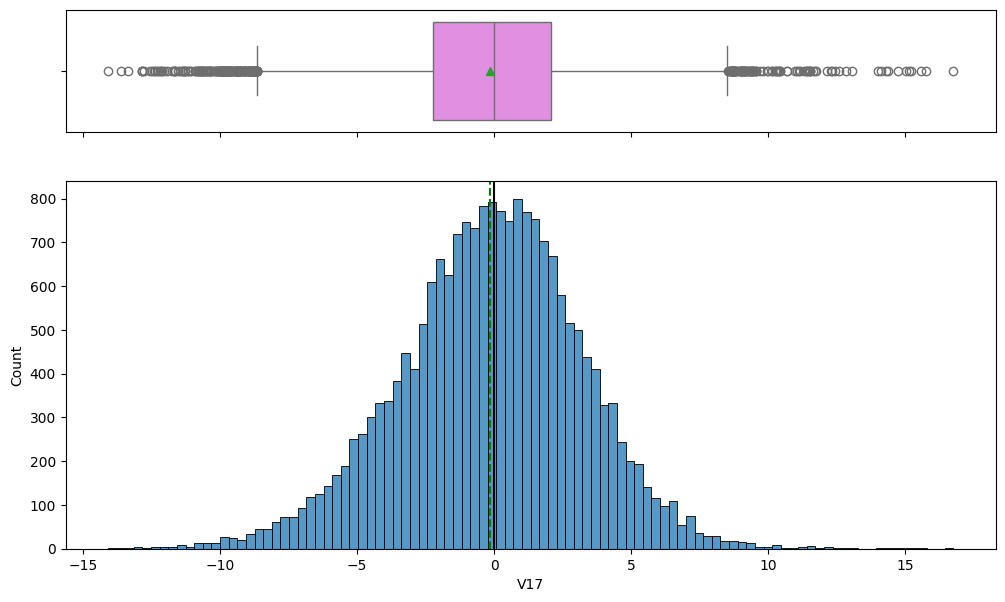

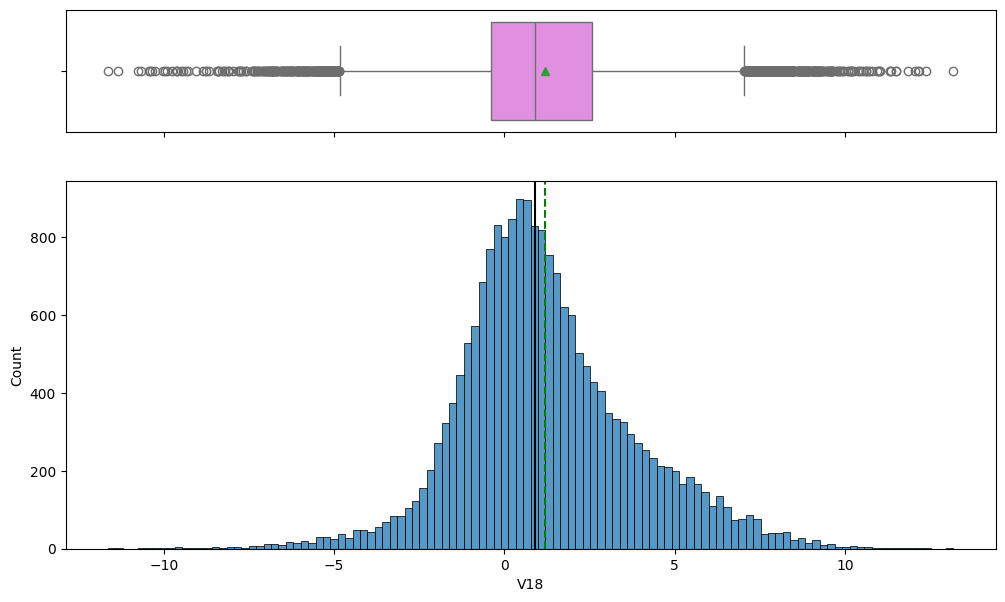

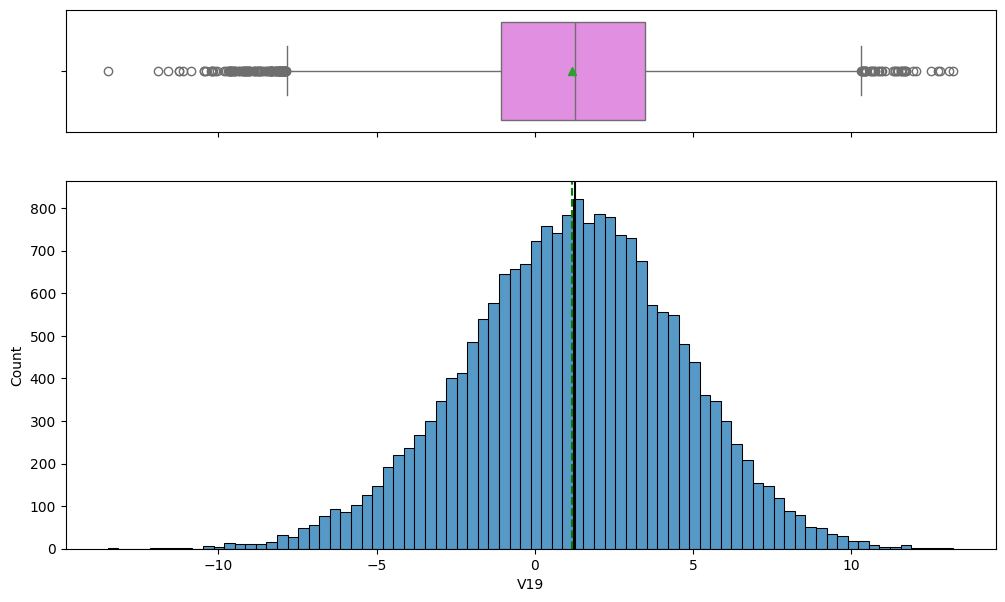

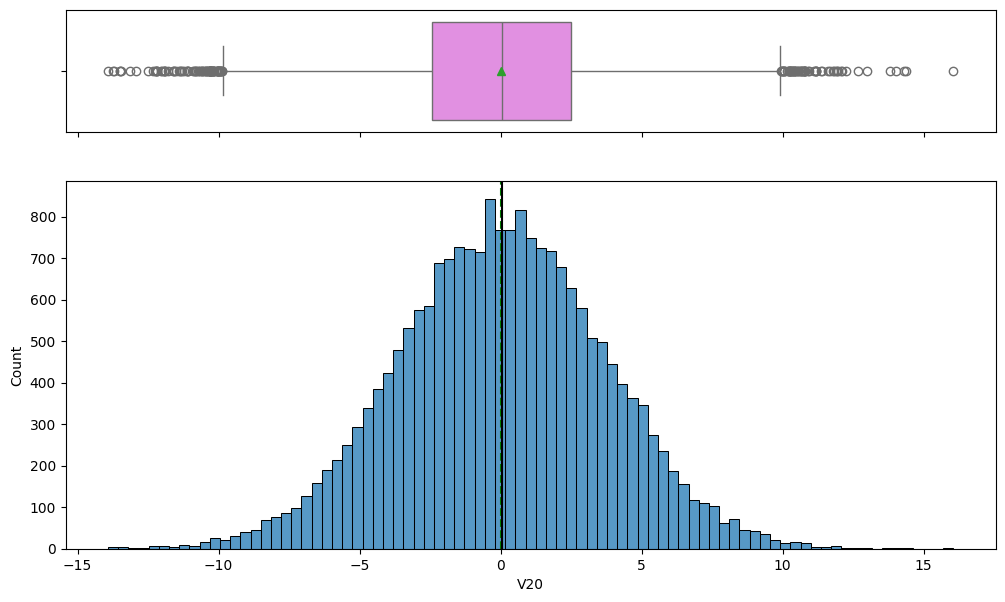

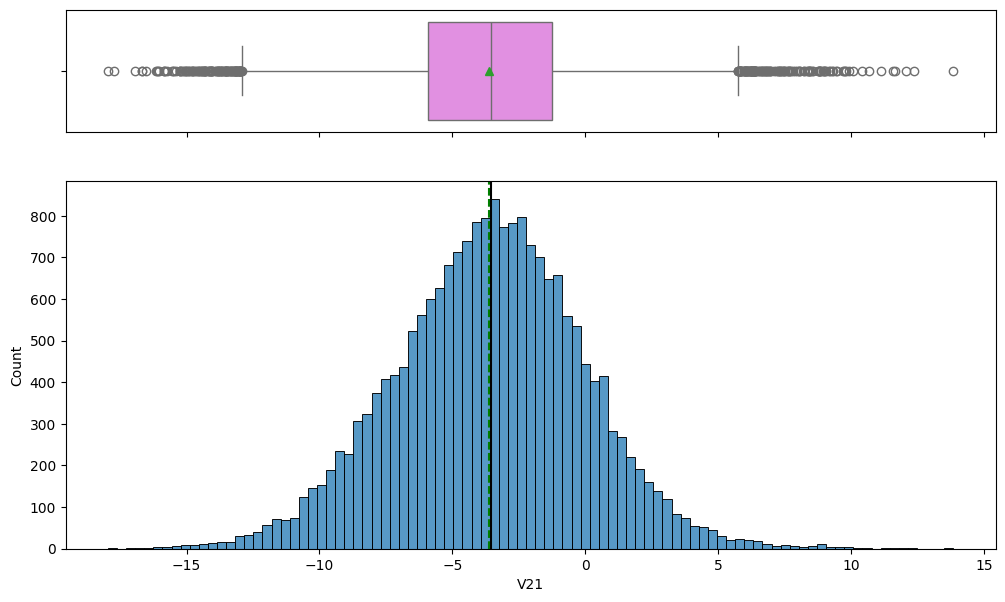

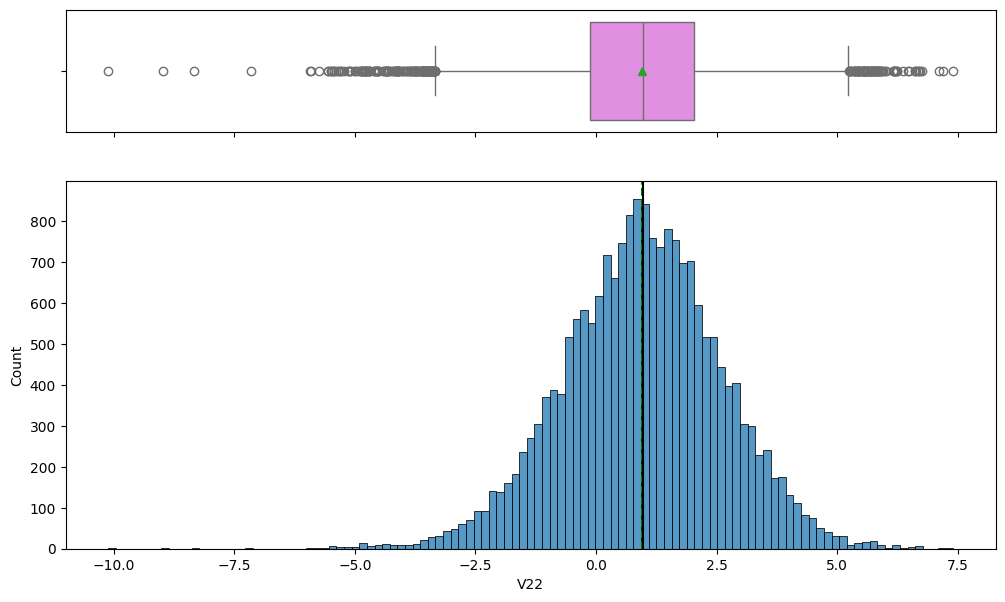

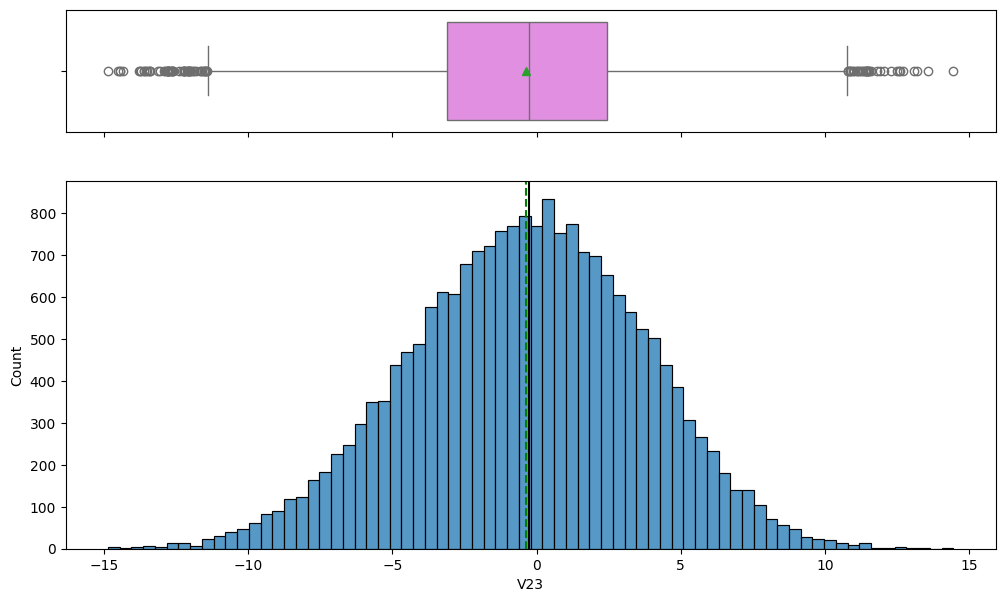

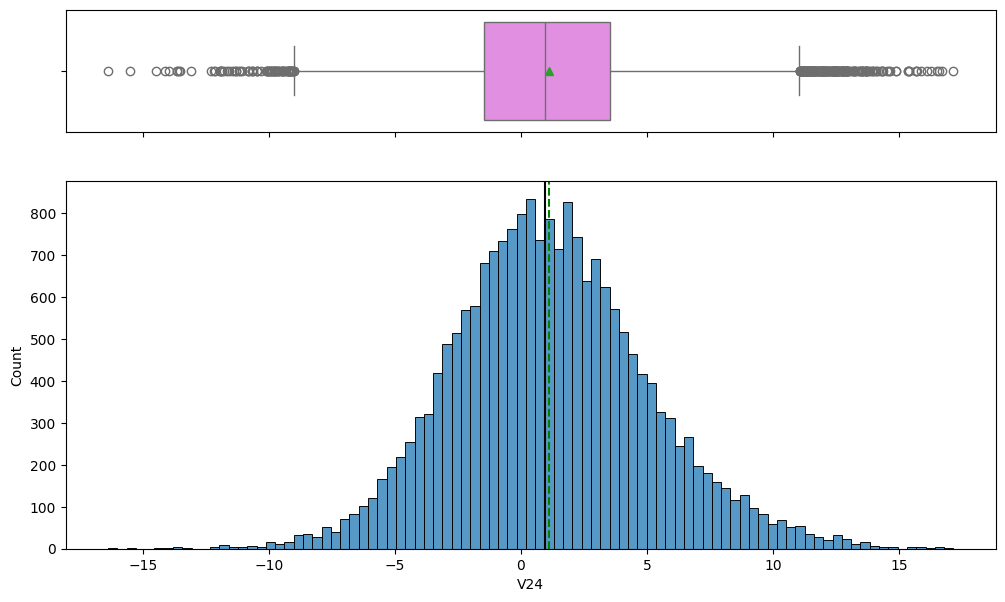

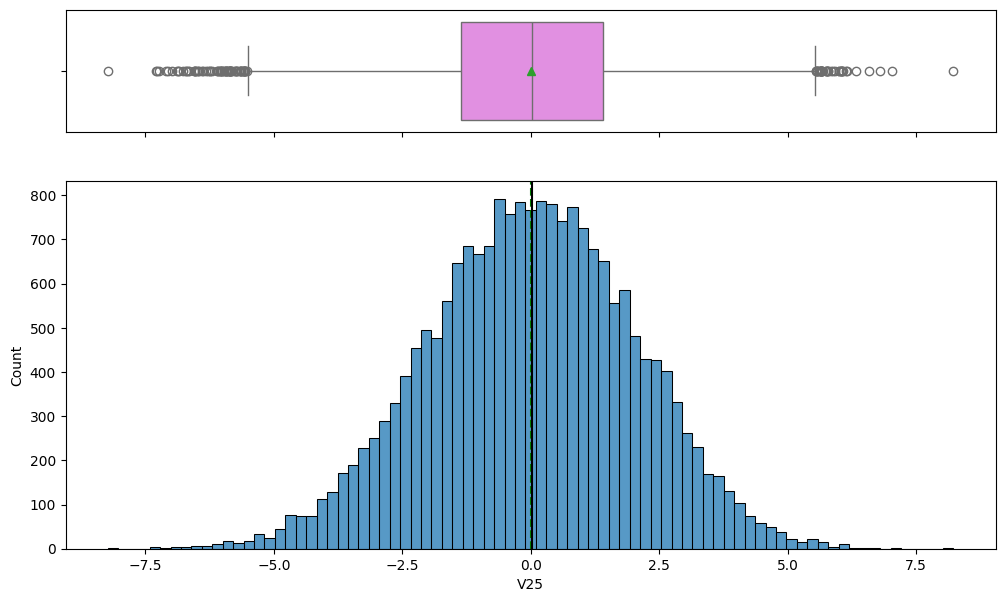

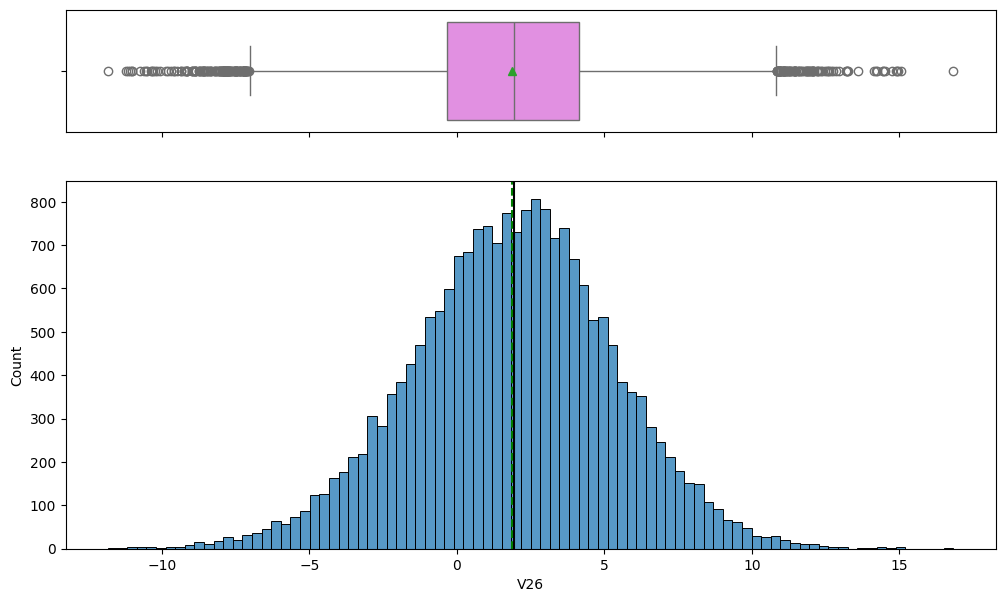

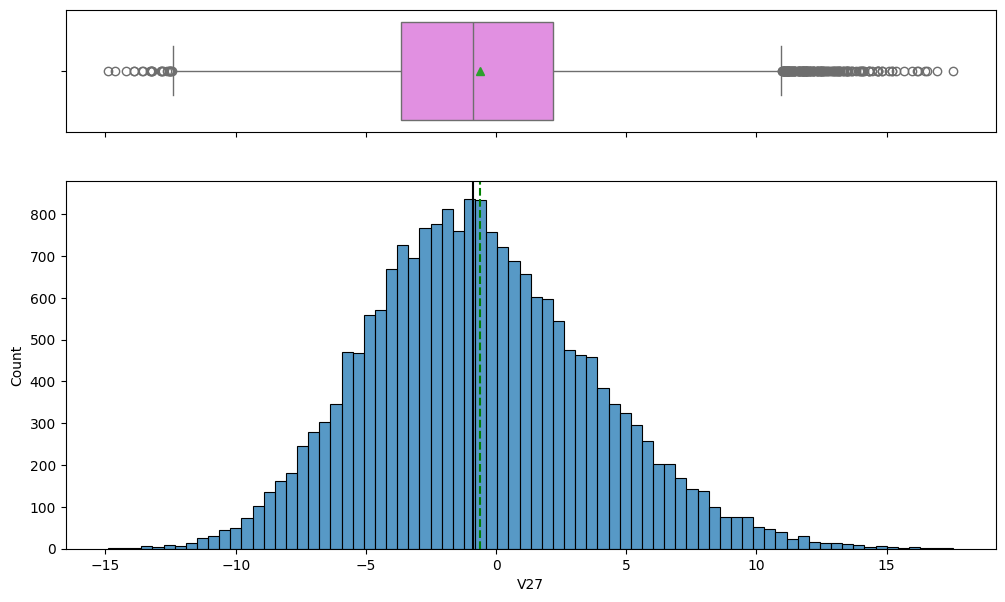

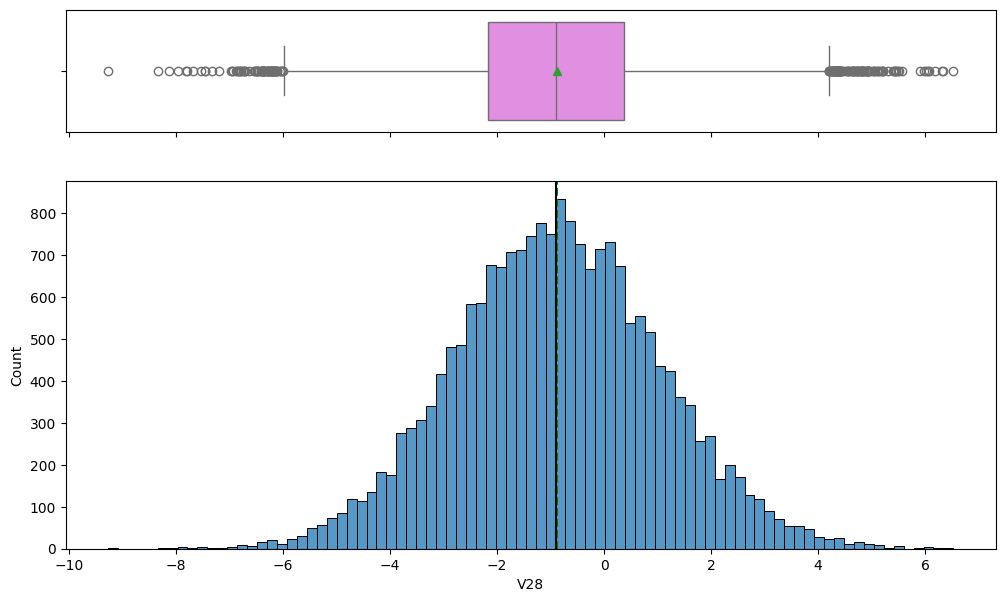

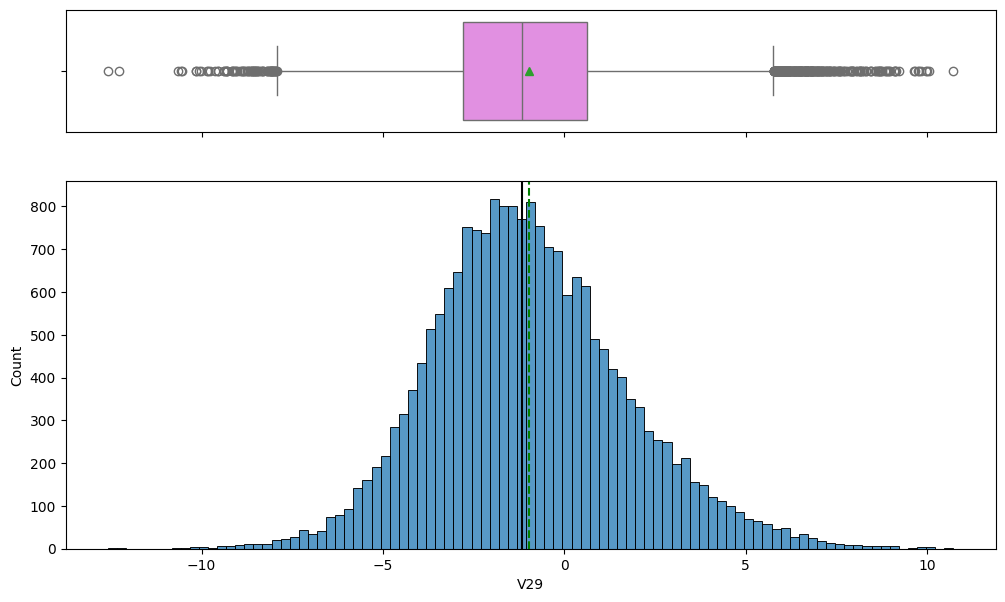

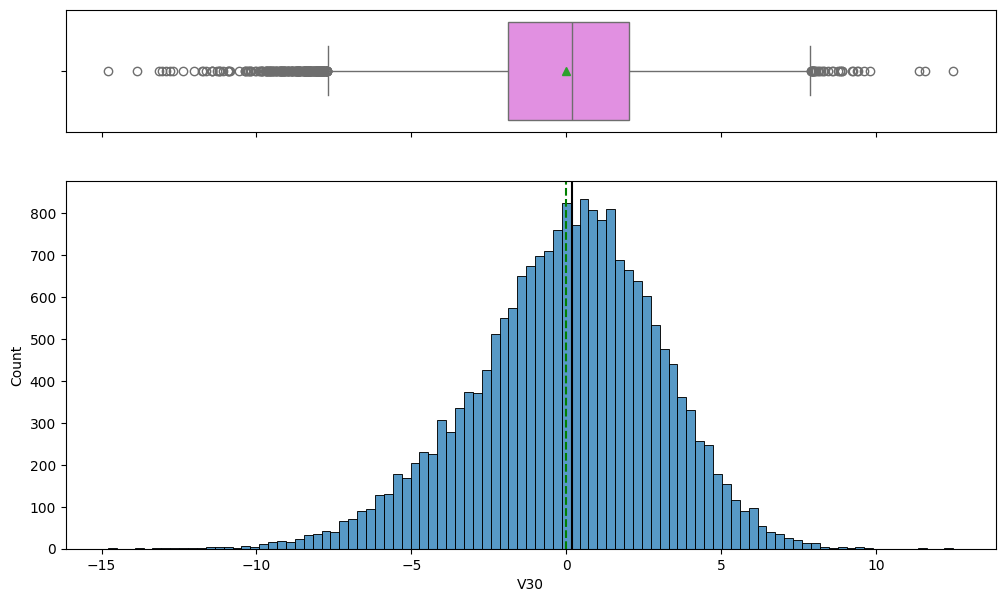

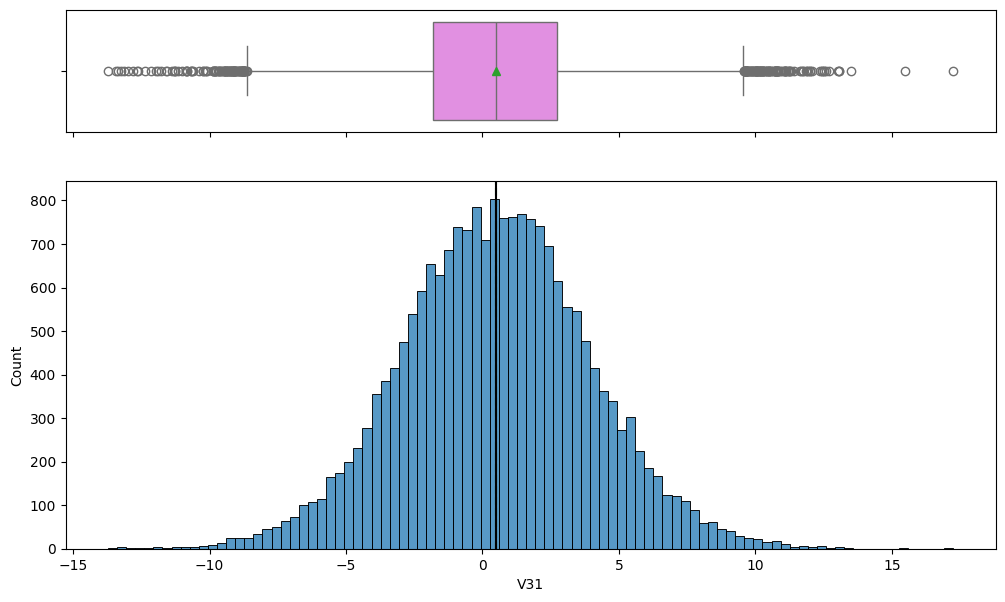

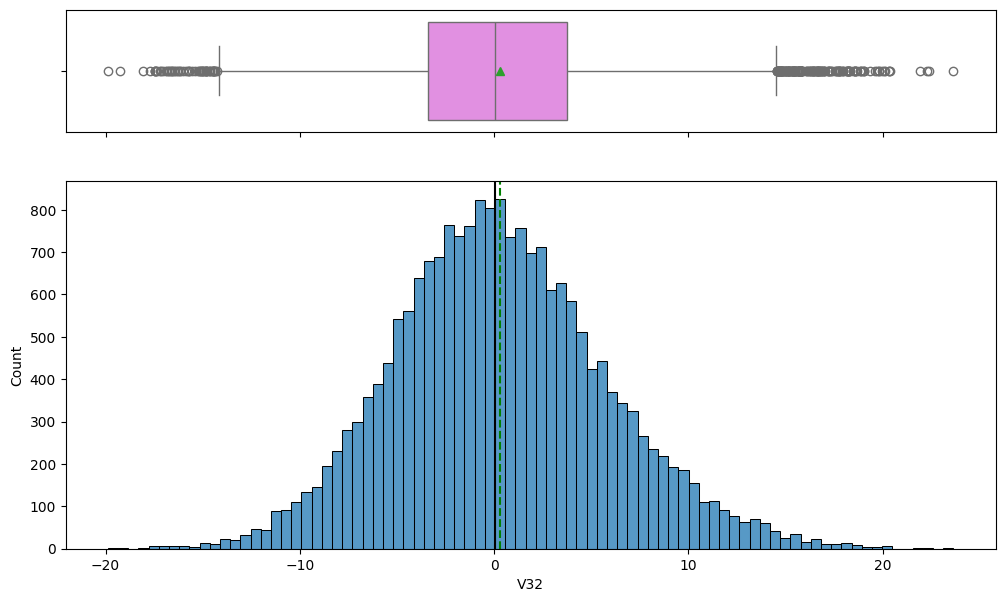

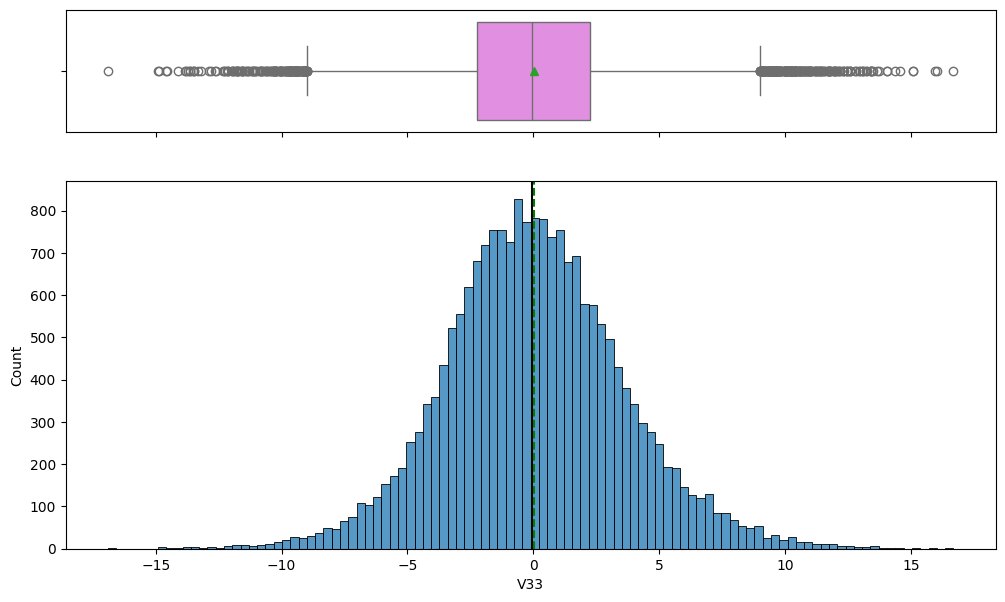

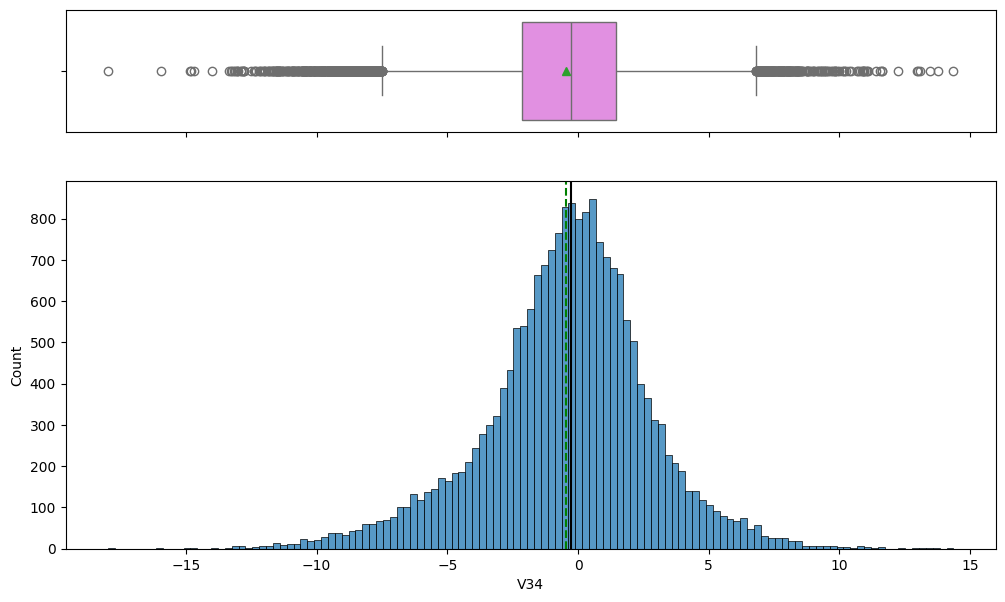

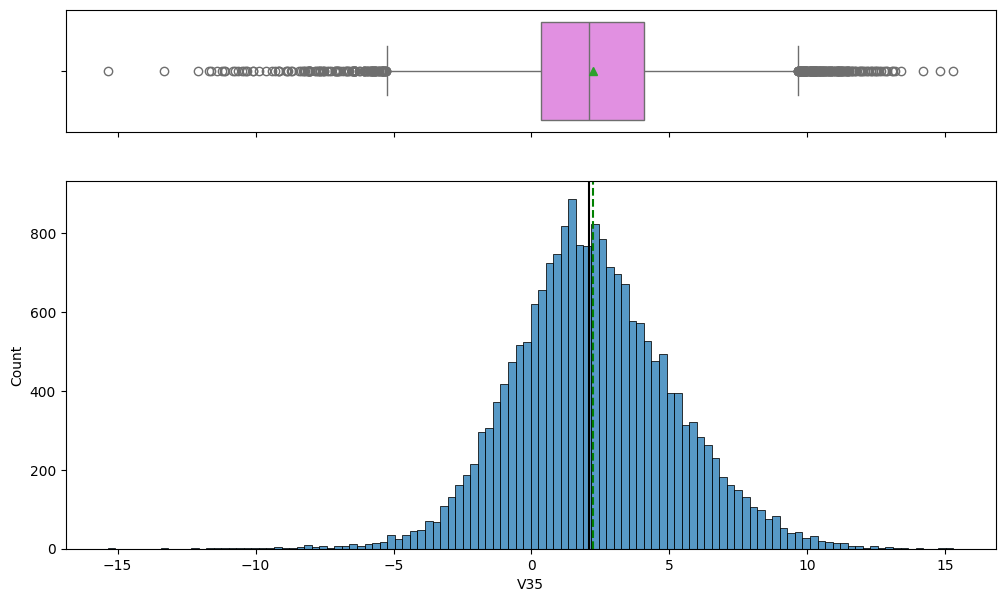

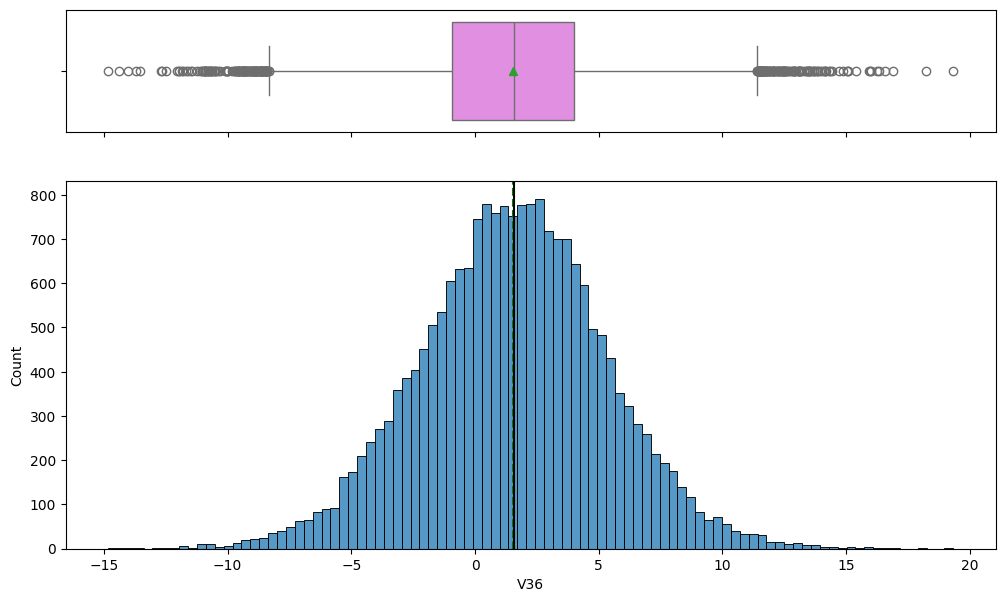

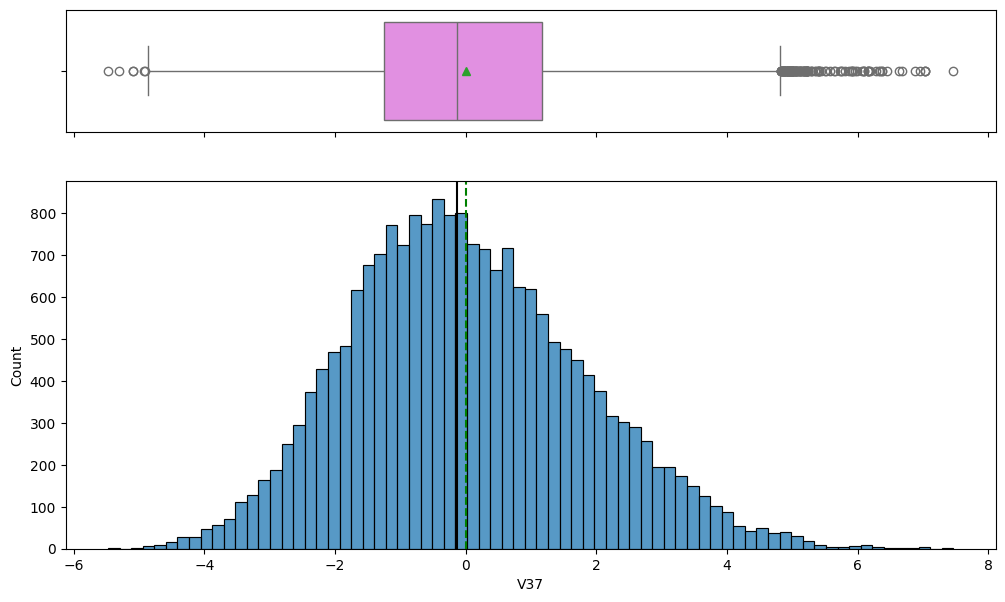

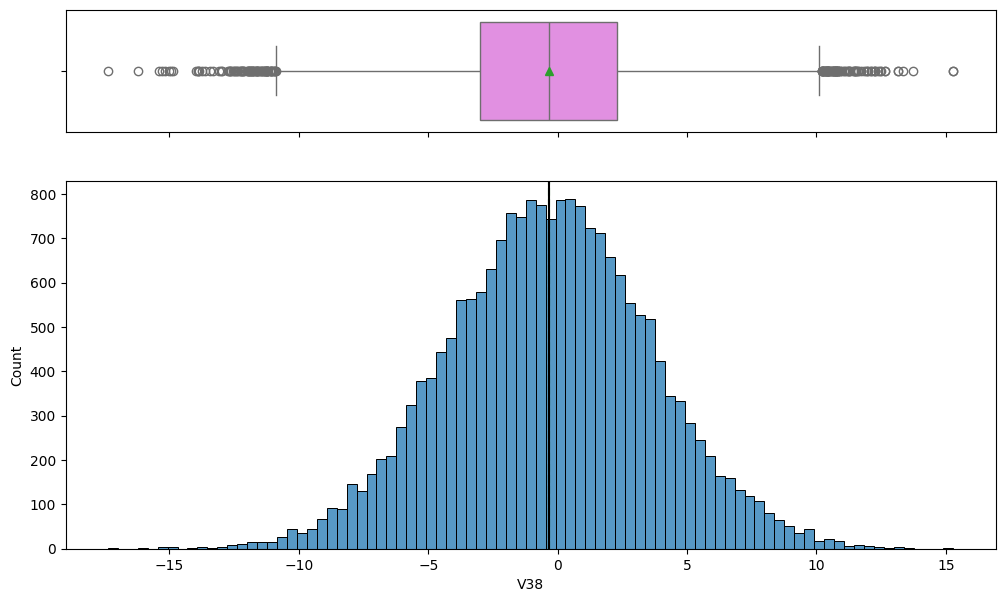

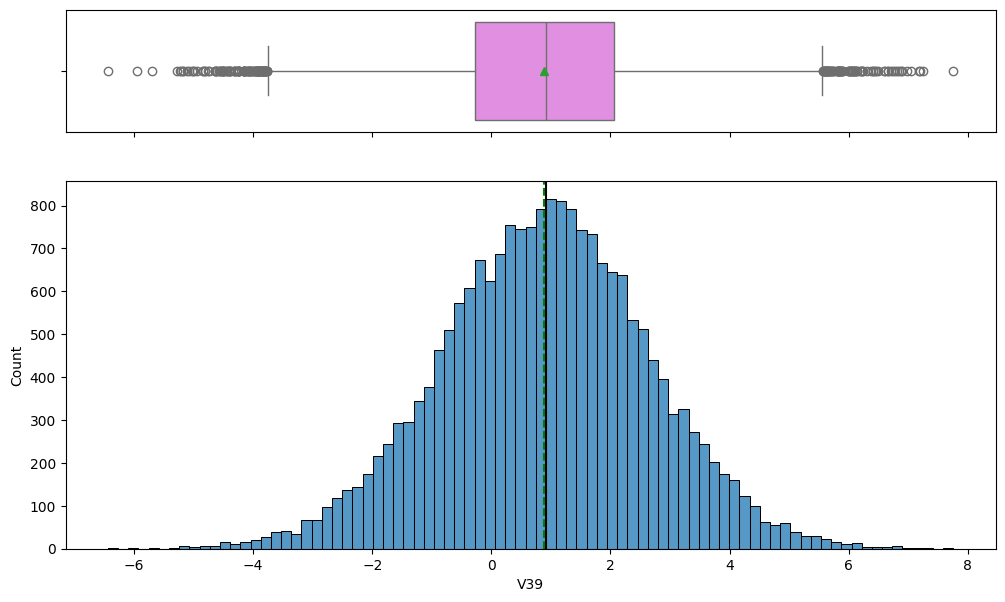

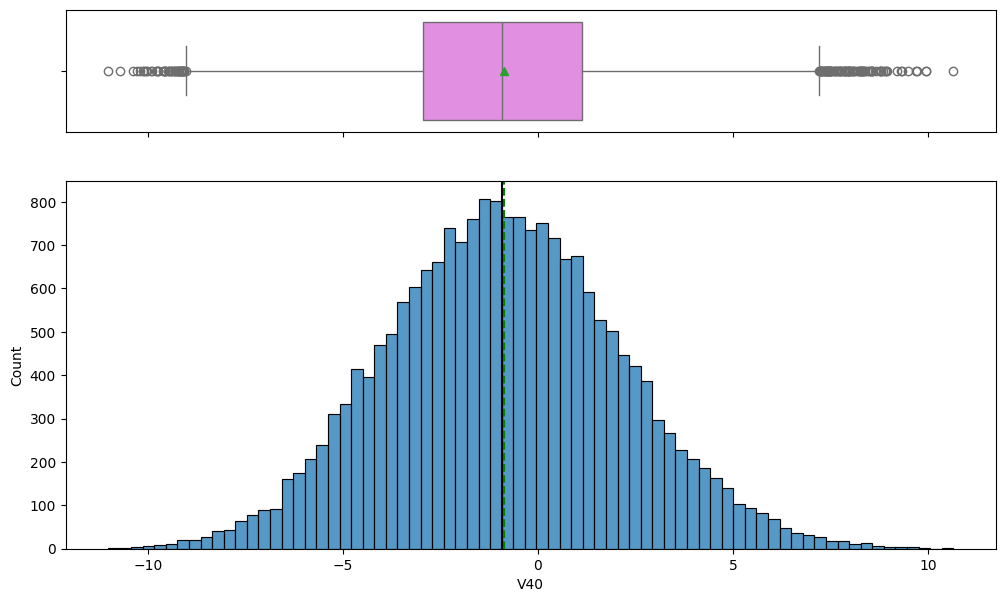

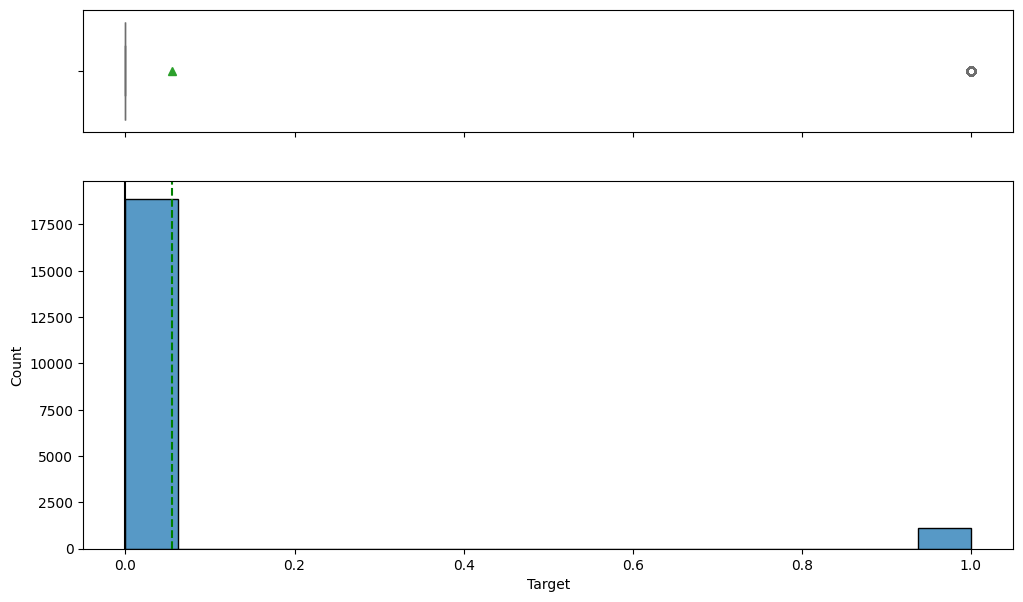

In [11]:
for feature in df_train.columns:
    histogram_boxplot(df_train, feature, figsize=(12, 7), kde=False, bins=None)

##Function to plot labeled bar plots for the Target variable


In [12]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [13]:
# Show class distribution in target variable in training data

df_train['Target'].value_counts()

,Target
0,18890
1,1110


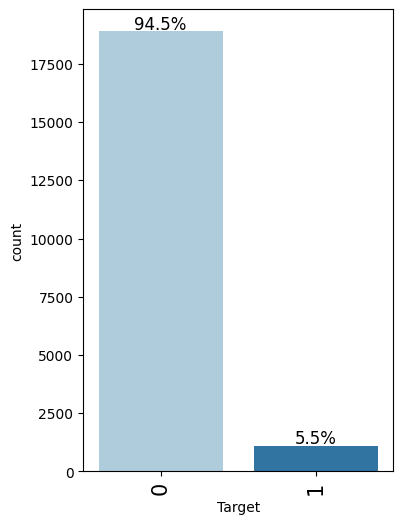

In [14]:
# Show class distribution in target variable in training data visually

labeled_barplot(df_train, "Target", perc=True)

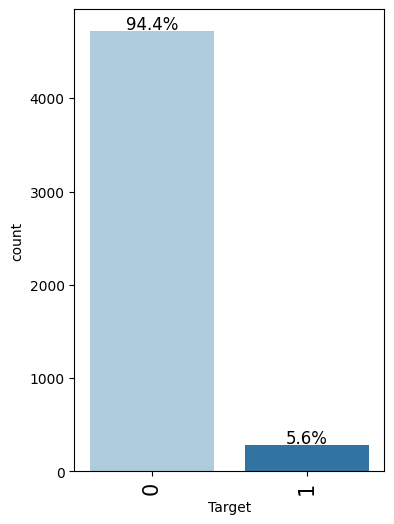

In [15]:
# Show class distribution in target variable in test data visually

labeled_barplot(df_test, "Target", perc=True)

**Observations**:
* There appears to be class imbalance in the target variable with the 0-No Failure class representing 94.5% of the data and the 1-Failure class representing 5.5% of the data
* Proportion of the classes is same in both training and test data

## Data Pre-processing

In [16]:
# Separating target variable and other variables
X_train = df_train.drop(columns="Target")
Y_train = df_train["Target"]
X_test = df_test.drop(columns="Target")
y_test = df_test["Target"]

In [17]:
# Splitting data into training, validation and test set:
# first we split data into two parts, temporary and test
# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=1, stratify=Y_train
)
print(X_train.shape, X_val.shape, X_test.shape)

(15000, 40) (5000, 40) (5000, 40)


In [18]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validation data =", X_val.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 15000
Number of rows in validation data = 5000
Number of rows in test data = 5000


## Missing value imputation




In [19]:
# creating an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

In [20]:
#replace the missing values in the train, validation, and test sets
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

In [21]:
#verify there are no missing values in the training data
X_train.isna().sum().sum()

0

In [22]:
#verify there are no missing values in the training data
X_val.isna().sum().sum()

0

In [23]:
#verify there are no missing values in the training data
X_test.isna().sum().sum()

0

**Observations:**

All dataframes have no missing values

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [24]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

In [25]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [26]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

Let's start by building different models using KFold and cross_val_score

We will implement the following models:

* Logistic Regression
* Decision Tree
* Bagging Classifier
* Random Forest Classifier
* Gradient Boosting Classifier
* Ada Boost Classifier
* XG Boost Classifier

Stratified K-Folds cross-validation provides dataset indices to split data into train/validation sets.
Split dataset into k consecutive folds keeping the distribution of both classes in each fold the same as the target variable.
Each fold is then used once as validation while the k - 1 remaining folds form the training set

Once the models are built, we will evaluate the performance of the models using the validation dataset

Sample Decision Tree model building with original data

In [27]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.6982829521679532
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.8100497799581561

Validation Performance:

dtree: 0.7050359712230215
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8309352517985612


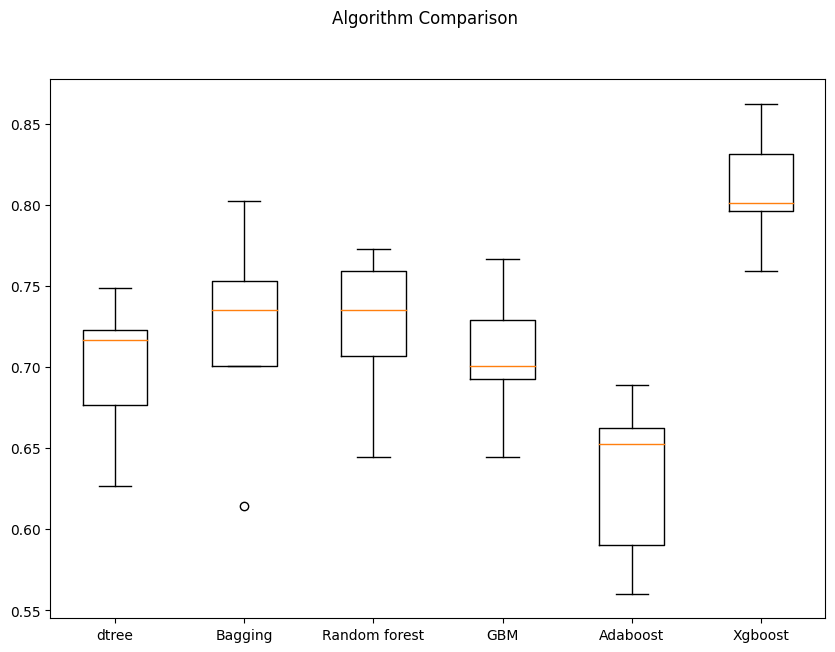

In [28]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

### Model Building with Oversampled data


To avoid giving greater preference to the prediction of the majority class i.e Class 0, we are using over-sampling techniques to balance class representation

Frequency of the Minority Class 1 is increased to provide a more balanced class representation

In [29]:
# Class size of Training Data Before Over-sampling
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 



In [30]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [31]:
# Class size of Training Data after Over-sampling
print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 



In [32]:
# Shape of Training Data after Over-sampling
print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



In [33]:
models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("Logistic regression", LogisticRegression(random_state=1)))
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results2 = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results2.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Logistic regression: 0.883963699328486
dtree: 0.9720494245534969
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
GBM: 0.9256068151319724
Adaboost: 0.8978689011775473
Xgboost: 0.9891305241357218

Validation Performance:

Logistic regression: 0.8489208633093526
dtree: 0.7769784172661871
Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
GBM: 0.8776978417266187
Adaboost: 0.8561151079136691
Xgboost: 0.8669064748201439


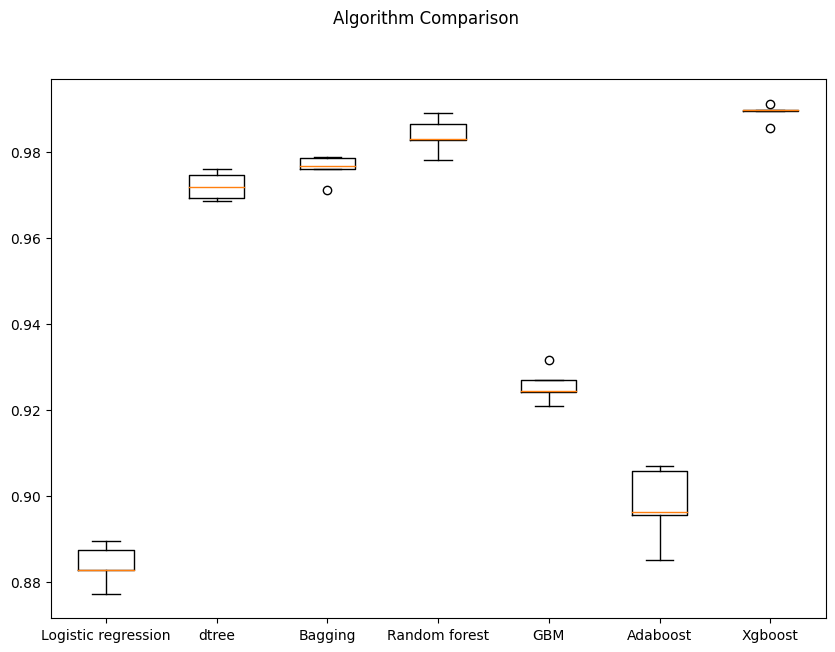

In [34]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results2)
ax.set_xticklabels(names_over)

plt.show()

**Observations:**
* There is a significant improvement in the CV scores of all the models compared to the models built using original data

* CV recall scores in the models range from 0.87 to 0.98

* Broadly, the performance of the models seem to have improved using oversampled data

* However, the CV scores of most models seem to be systematically higher than the scores obtained on the validation set suggesting a moderate degree of overfitting

* This suggests that most of the models seems to generalize to some extent but not exceptionally well

* Top 3 models with highest recall on validation set appears to be Gradient Boosting, XGBoost and Random Forest

* Hyperparameter tuning may be helpful to further improve the performances of these models using oversampled data as well as help reduce the amount of overfitting

### Model Building with Undersampled data

In [35]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("Before Undersampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Undersampling, counts of label 'Yes': {}".format(sum(y_train_under == 1)))
print("After Undersampling, counts of label 'No': {} \n".format(sum(y_train_under == 0)))

print("After Undersampling, the shape of X_train: {}".format(X_train_under.shape))
print("After Undersampling, the shape of y_train: {} \n".format(y_train_under.shape))

Before Undersampling, counts of label 'Yes': 832
Before Undersampling, counts of label 'No': 14168 

After Undersampling, counts of label 'Yes': 832
After Undersampling, counts of label 'No': 832 

After Undersampling, the shape of X_train: (1664, 40)
After Undersampling, the shape of y_train: (1664,) 



In [36]:
models_under = []  # Empty list to store all the models

# Appending models into the list
models_under.append(("Logistic regression", LogisticRegression(random_state=1)))
models_under.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_under.append(("Bagging", BaggingClassifier(random_state=1)))
models_under.append(("Random forest", RandomForestClassifier(random_state=1)))
models_under.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_under.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_under.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results3 = []  # Empty list to store all model's CV scores
names_under = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models_under:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scorer, cv=kfold
    )
    results3.append(cv_result)
    names_under.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_under:
    model.fit(X_train_under, y_train_under)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

Logistic regression: 0.8726138085275232
dtree: 0.8617776495202367
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
GBM: 0.8990621167303946
Adaboost: 0.8666113556020489
Xgboost: 0.9014717552846114

Validation Performance:

Logistic regression: 0.8525179856115108
dtree: 0.841726618705036
Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
GBM: 0.8884892086330936
Adaboost: 0.8489208633093526
Xgboost: 0.89568345323741


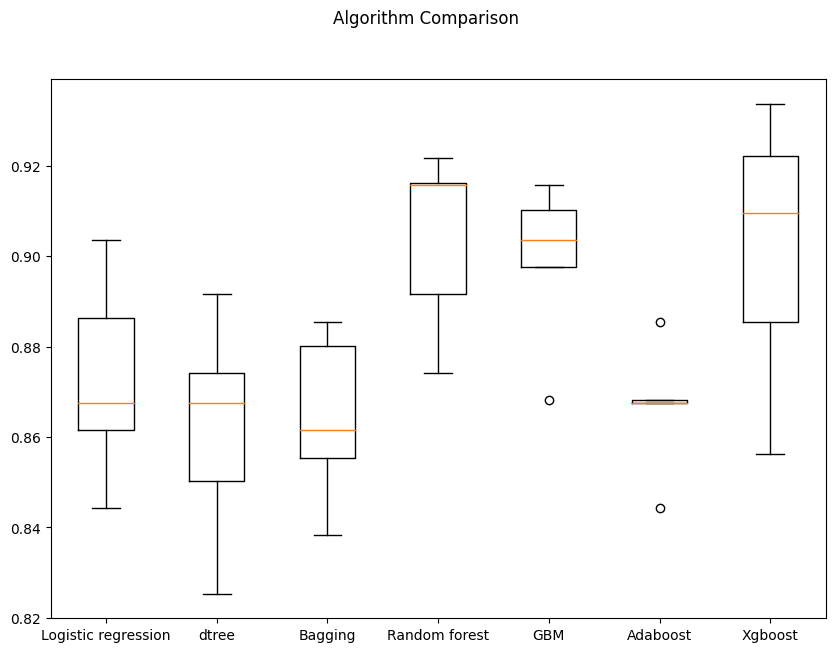

In [37]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results3)
ax.set_xticklabels(names_under)

plt.show()

Observations:
* There is significant improvement in the CV scores of all the models compared to the models built using original data

* CV recall scores in the models range from 0.85 to 0.9

* The CV scores are generally slightly lower than the equivalent models built using oversampling techniques and thus perform slightly worse compared to models using oversampling

* However, the CV scores of most models seem to be very similar to the scores obtained on the validation set. Looks like the models using undersampled data seem to generalize quite well, slightly better than the models built using oversampling

* Top 3 models with highest recall on validation set appears to be Gradient Boosting, Random Forest and XGBoost

* Hyperparameter tuning may be helpful to further improve the performances of these models using undersampled data

## Hyperparameter Tuning

- Hyperparameter tuning can help improve model performance as well help to reduce both overfitting or underfitting

- Generally the **default models using the original data** with imbalanced classes performs poorly (low recall score) and appears to be underfit (poor performance in both training and validation)

- We can attempt to improve performance using hyperparameter tuning in these models

- Models using **oversampling techniques** have the best performance but appear to be slightly overfit with validation data scores systematically lower than the CV scores

- We can use hyperparameter tuning to see if we could reduce the overfitting and improve performance

- Models using **undersampling techniques** have slightly lower performance scores compared to the models using oversampled data but appear to generalize better with very similar CV scores and validation scores.

- We can use hyperparameter tuning to see if we could primarily improve performance




### Approach for Hyperparameter tuning

- In terms of performance based on CV score alone, few of the top five models are
  - Random Forest with oversampled data,
  - Bagging classifier with oversampled data,
  - Decision Tree with oversampled data,
  - Gradient Boosting with oversampled data
  - XGB with oversampled data

- However, all of these models suffer from slight overfitting and we will tune hyperparameters to see how much we can improve them and reduce overfitting

- In terms of both performance and model generalization, few of the top five models are
 - Random Forest with undersampled data,
 - Gradient Boosting with undersampled data,
 - XGB with undersampled data,
 - Bagging classifier with undersampled data
 - Ada Boost with undersampled data

- We will focus on improving performance for these models using hyperparameter tuning

- Instead of selecting just a few models for hyperparameter tuning , we will be tuning 15 models (all models except Bagging Classifier and Ada Boost Classifier) with default, over- and undersampled data with the objective of either
 - improve performance and reduce underfitting (Default models)
 - reduce overfitting and generalize better as well as further improve performance (Models using oversampled data)
 - improve performance (Models using undersampled data)

- **Bagging Classifier models have been left out** from tuning because they are extremely time intensive for computation and produce very poorly generalized, highly overfit models **[NOTE: These models were tuned earlier but excluded in final solution]**

- **Ada Boost Classifier models have been left out** from tuning because they are are extremely time intensive for computation and their pre-tuned performance isn't significantly better compared to the other models **[NOTE: These models were tuned earlier but excluded in final solution]**


### Selection of Top Models for Hyperparamater Tuning

- Although we will be tuning additional models to see how hyper-parameter tuning affects performance and generalization across different models, we will highlight here top 7 models to be selected in case there are time constraints to tune all models

- Top models to select for Hyperparameter tuning are as follows
  - (1) Random Forest with Oversampling
  - (2) Bagging Classifier with Oversampling
  - (3) Gradient Boosting with Oversampling
  - (4) XGBoost with Oversampling
  - (5) Random Forest with Undersampling
  - (6) Gradient Boosting with Undersampling
  - (7) XGBoost with Undersampling

- Reasons for selection of the above models in scenarios where time is limited and all 21 models cannot be tuned are
  - Models (1) to (4) are selected because they perform really well with high recall CV score but suffer from slight overfitting. Hyperparamater tuning may help to generalize them without losing much performance
  - Models (5) to (7) are selected because they generalize quite well with relatively high performance. Tuning may help further improve performance without losing generalization
  - Model (2) should be skipped if there are time limitations as it is the most computationally expensive amongst these 7 models

- NOTE: This is done here for consistency purposes related to the grading rubric

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### 1. Hyperparameter tuning Logistic Regression with original data

In [38]:

# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.2} with CV score=0.4952240098117019:
CPU times: user 303 ms, sys: 149 ms, total: 452 ms
Wall time: 4.86 s


In [39]:
# Creating new pipeline with best parameters
tuned_lr1 = LogisticRegression(random_state=1,C=0.1)

tuned_lr1.fit(X_train,y_train)

LogisticRegression(C=0.1, random_state=1)

In [40]:
# Calculating different metrics on train set
tuned_lr1_train_perf = model_performance_classification_sklearn(tuned_lr1, X_train, y_train)
tuned_lr1_train_perf

,Accuracy,Recall,Precision,F1
0,0.97,0.50,0.85,0.62


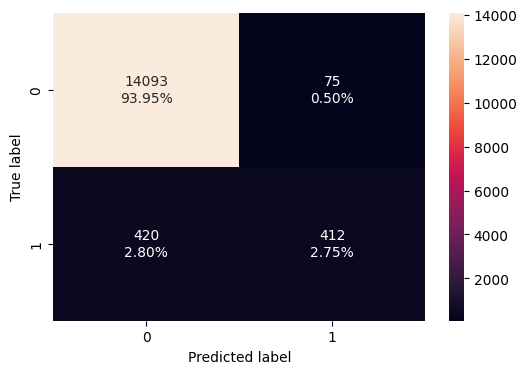

In [41]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_lr1, X_train, y_train)

In [42]:
# Calculating different metrics on validation set
tuned_lr1_val_perf = model_performance_classification_sklearn(tuned_lr1, X_val, y_val)
tuned_lr1_val_perf

,Accuracy,Recall,Precision,F1
0,0.97,0.48,0.84,0.61


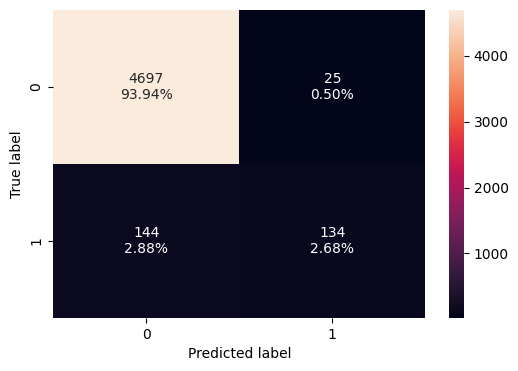

In [43]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_lr1, X_val, y_val)

#### Comments on hyperparameter tuning Logistic regression model with original data

- Training and validation recall scores are very poor (< 0.5)

- Recall scores is very similar to non-tuned logistic regression models with original data and havent improved

- Model is extremely poor in correctly predicting the minority class (class '1')

### 2. Hyperparameter tuning Logistic Regression with oversampled data

In [44]:

# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.1} with CV score=0.8838231041005031:
CPU times: user 399 ms, sys: 149 ms, total: 548 ms
Wall time: 6.55 s


In [45]:
# Creating new pipeline with best parameters
tuned_lr2 = LogisticRegression(random_state=1,C=0.1)

tuned_lr2.fit(X_train_over,y_train_over)

LogisticRegression(C=0.1, random_state=1)

In [46]:
# Calculating different metrics on train set
tuned_lr2_train_perf = model_performance_classification_sklearn(tuned_lr2, X_train_over, y_train_over)
tuned_lr2_train_perf

,Accuracy,Recall,Precision,F1
0,0.88,0.88,0.88,0.88


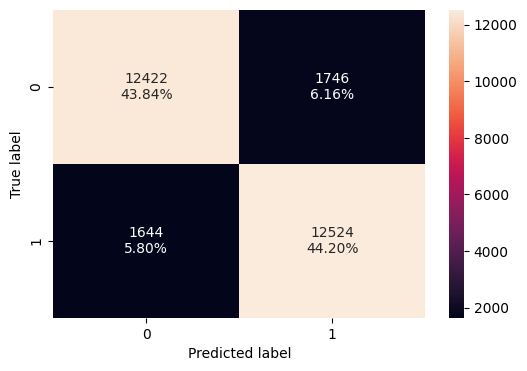

In [47]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_lr2, X_train_over, y_train_over)

In [48]:
# Calculating different metrics on validation set
tuned_lr2_val_perf = model_performance_classification_sklearn(tuned_lr2, X_val, y_val)
tuned_lr2_val_perf

,Accuracy,Recall,Precision,F1
0,0.87,0.85,0.28,0.42


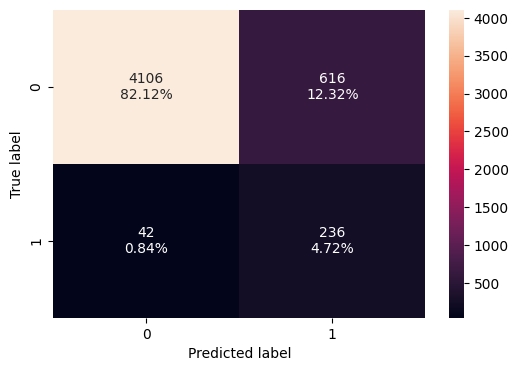

In [49]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_lr2, X_val, y_val)

#### Comments on hyperparameter tuning Logistic regression model with oversampled data

- Recall has significantly improved to 0.84 in validation set compared to the model using original data

- Training and validation set recall scores are similar suggesting reasonable model generalization with respect to recall

- Precision and F1 score are quite poor (0.28 and 0.42) in validation set and much lower compared to the scores in training set

- This suggests that the model performance and generalization are both very poor with respect to precision and F1 score

### 3. Hyperparameter tuning Logistic Regression with undersampled data

In [50]:

# defining model
Model = LogisticRegression(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.1} with CV score=0.8653560349181155:
CPU times: user 87.1 ms, sys: 19.9 ms, total: 107 ms
Wall time: 941 ms


In [51]:
# Creating new pipeline with best parameters
tuned_lr3 = LogisticRegression(random_state=1,C=0.1)

tuned_lr3.fit(X_train_under,y_train_under)

LogisticRegression(C=0.1, random_state=1)

In [52]:
# Calculating different metrics on train set
tuned_lr3_train_perf = model_performance_classification_sklearn(tuned_lr3, X_train_under, y_train_under)
tuned_lr3_train_perf

,Accuracy,Recall,Precision,F1
0,0.87,0.88,0.87,0.87


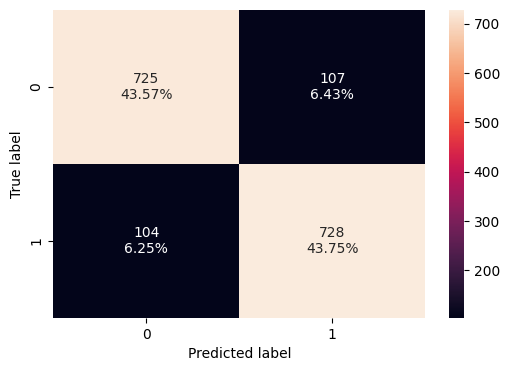

In [53]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_lr3, X_train_under, y_train_under)

In [54]:
# Calculating different metrics on validation set
tuned_lr3_val_perf = model_performance_classification_sklearn(tuned_lr3, X_val, y_val)
tuned_lr3_val_perf

,Accuracy,Recall,Precision,F1
0,0.86,0.85,0.26,0.40


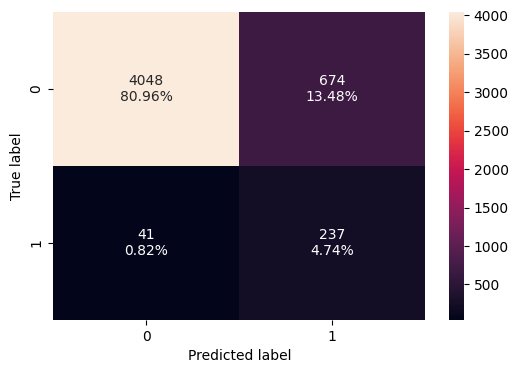

In [55]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_lr3, X_val, y_val)

#### Comments on hyperparameter tuning Logistic regression model with undersampled data

- Recall in validation set is very similar to model using oversampling

- Model seems to generalize well with respect to recall score

- Precision and F1 score are very poor (0.26 and 0.405) in validation set and much lower compared to the scores in training set

- This suggests that the model performance and generalization are both very poor with respect to precision and F1 score

### 4. Hyperparameter tuning Decision tree with original data

In [56]:

# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.5684366207344347:
CPU times: user 782 ms, sys: 19 ms, total: 801 ms
Wall time: 11 s


In [57]:
# Creating new pipeline with best parameters
tuned_dt1 = DecisionTreeClassifier(random_state=1,min_samples_leaf=7, min_impurity_decrease = 0.0001, max_leaf_nodes = 15, max_depth = 5)

tuned_dt1.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, min_samples_leaf=7,
                       random_state=1)

In [58]:
# Calculating different metrics on train set
tuned_dt1_train_perf = model_performance_classification_sklearn(tuned_dt1, X_train, y_train)
tuned_dt1_train_perf

,Accuracy,Recall,Precision,F1
0,0.97,0.59,0.90,0.72


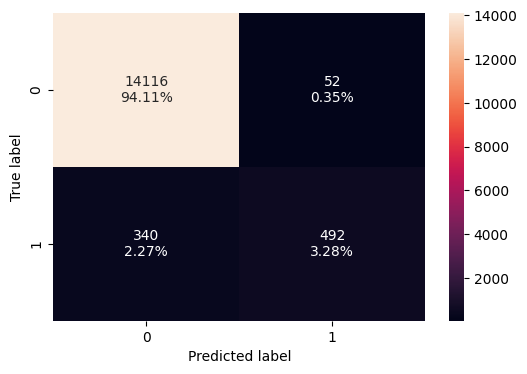

In [59]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_dt1, X_train, y_train)

In [60]:
# Calculating different metrics on validation set
tuned_dt1_val_perf = model_performance_classification_sklearn(tuned_dt1, X_val, y_val)
tuned_dt1_val_perf

,Accuracy,Recall,Precision,F1
0,0.97,0.58,0.82,0.68


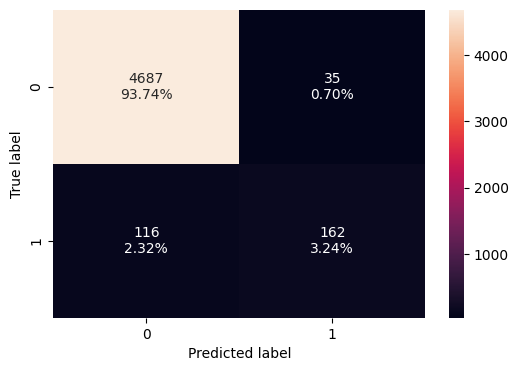

In [61]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_dt1, X_val, y_val)

#### Comments on hyperparameter tuning Decision Tree model with original data

- Recall score is not very high (~0.65)

- Recall scores is poorer compared to pre-tuned models and this may partly arise from the range of parameters in the parameter grid and the use of Randomized grid search as opposed to the more extensive grid search

- Model generalizes well with respect to most performance metrics and is not very overfit

### 5. Hyperparameter tuning Decision tree with oversampled data

In [62]:

# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3} with CV score=0.9102913265648006:
CPU times: user 774 ms, sys: 52.1 ms, total: 826 ms
Wall time: 21.4 s


In [63]:
# Creating new pipeline with best parameters
tuned_dt2 = DecisionTreeClassifier(random_state=1,min_samples_leaf=7, min_impurity_decrease = 0.0001, max_leaf_nodes = 15, max_depth = 5)

tuned_dt2.fit(X_train_over,y_train_over)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, min_samples_leaf=7,
                       random_state=1)

In [64]:
# Calculating different metrics on train set
tuned_dt2_train_perf = model_performance_classification_sklearn(tuned_dt2, X_train_over, y_train_over)
tuned_dt2_train_perf

,Accuracy,Recall,Precision,F1
0,0.90,0.89,0.90,0.90


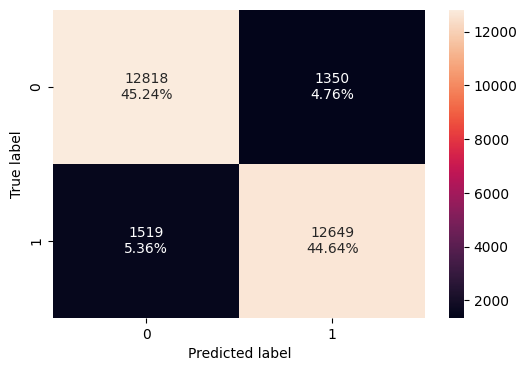

In [65]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_dt2, X_train_over, y_train_over)

In [66]:
# Calculating different metrics on validation set
tuned_dt2_val_perf = model_performance_classification_sklearn(tuned_dt2, X_val, y_val)
tuned_dt2_val_perf

,Accuracy,Recall,Precision,F1
0,0.89,0.86,0.32,0.47


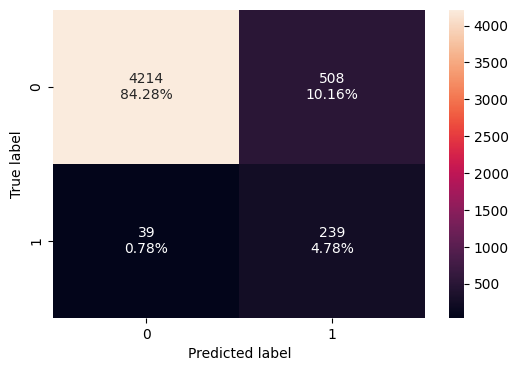

In [67]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_dt2, X_val, y_val)

#### Comments on hyperparameter tuning Decision Tree model with oversampled data

- Recall score has improved to 0.81 in validation set compared to model built with original data

- Model appears slightly overfit with respect to recall with validation score slightly lower compared to training set score

- Model appears quite overfit with respect to precision and F1 score with model performing poorly on validation data


### 6. Hyperparameter tuning Decision tree with undersampled data

In [68]:

# defining model
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,20),
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 5, 'max_depth': 2} with CV score=0.850811629752543:
CPU times: user 92.9 ms, sys: 8.03 ms, total: 101 ms
Wall time: 1.22 s


In [69]:
# Creating new pipeline with best parameters
tuned_dt3 = DecisionTreeClassifier(random_state=1,min_samples_leaf=1, min_impurity_decrease = 0.001, max_leaf_nodes = 15, max_depth = 11)

tuned_dt3.fit(X_train_under,y_train_under)

DecisionTreeClassifier(max_depth=11, max_leaf_nodes=15,
                       min_impurity_decrease=0.001, random_state=1)

In [70]:
# Calculating different metrics on train set
tuned_dt3_train_perf = model_performance_classification_sklearn(tuned_dt3, X_train_under, y_train_under)
tuned_dt3_train_perf

,Accuracy,Recall,Precision,F1
0,0.91,0.88,0.95,0.91


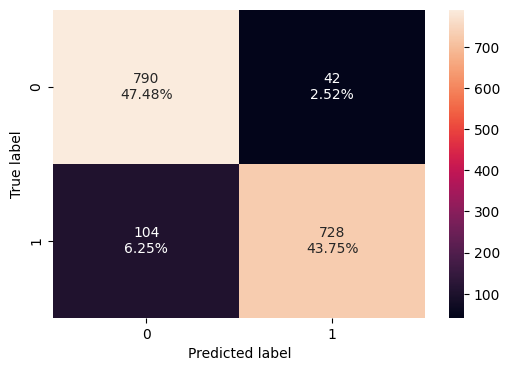

In [71]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_dt3, X_train_under, y_train_under)

In [72]:
# Calculating different metrics on validation set
tuned_dt3_val_perf = model_performance_classification_sklearn(tuned_dt3, X_val, y_val)
tuned_dt3_val_perf

,Accuracy,Recall,Precision,F1
0,0.90,0.85,0.34,0.48


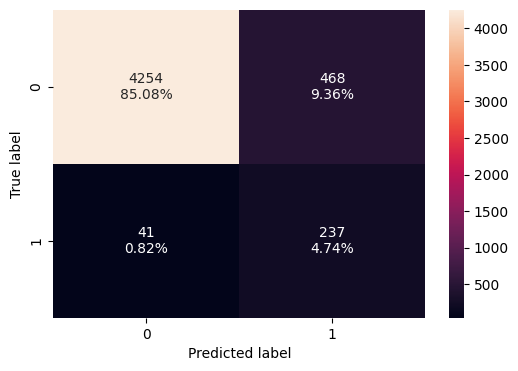

In [73]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_dt3, X_val, y_val)

#### Comments on hyperparameter tuning Decision Tree model with undersampled data

- Recall score in validation set is similar to oversampled data model

- Model appears slightly overfit with respect to recall with validation score slightly lower compared to training score

- Model is very overfit with respect to precision and F1 score with model performing poorly on validation data

- Limited range of hyperparameters and use of Randomized Grid search may be responsible for similar poor performances in models using oversampled and undersampled techniques

### 7. Hyperparameter tuning Random Forest Classifer with original data

In [74]:

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6996248466921577:
CPU times: user 30 s, sys: 693 ms, total: 30.7 s
Wall time: 8min 56s


In [75]:
# Creating new pipeline with best parameters
tuned_rf1 = RandomForestClassifier(random_state=1,n_estimators = 300, min_samples_leaf = 1, max_samples = 0.6, max_features = 'sqrt')

tuned_rf1.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.6, n_estimators=300, random_state=1)

In [76]:
# Calculating different metrics on train set
tuned_rf1_train_perf = model_performance_classification_sklearn(tuned_rf1, X_train, y_train)
tuned_rf1_train_perf

,Accuracy,Recall,Precision,F1
0,1.00,0.91,1.00,0.95


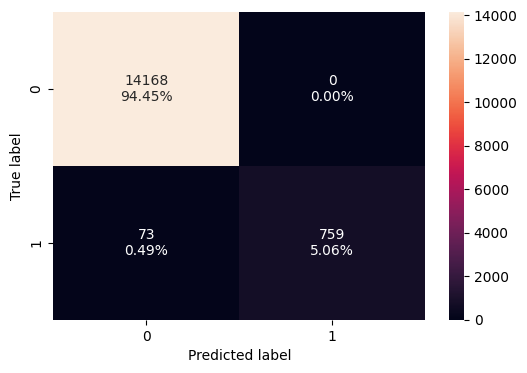

In [77]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_rf1, X_train, y_train)

In [78]:
# Calculating different metrics on validation set
tuned_rf1_val_perf = model_performance_classification_sklearn(tuned_rf1, X_val, y_val)
tuned_rf1_val_perf

,Accuracy,Recall,Precision,F1
0,0.98,0.71,0.99,0.83


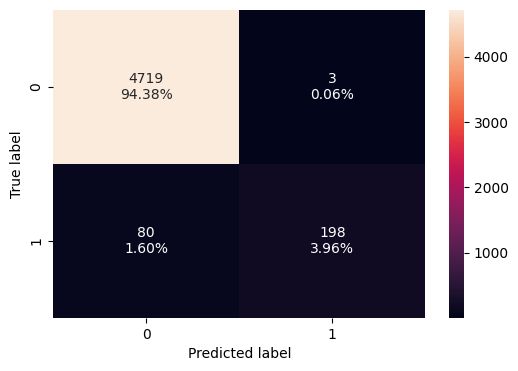

In [79]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_rf1, X_val, y_val)

#### Comments on hyperparameter tuning Random Forest model with original data

- Model appears to be overfitting with respect to recall score

- Model validation recall is very similar to pre-tuned model and not much improved

- Model precision and accuracy is high and generalizes well but the model does a poorer job in predicting the minority class

### 8. Hyperparameter tuning Random Forest Classifer with oversampled data

In [80]:

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9815078165615898:
CPU times: user 51.9 s, sys: 1.02 s, total: 53 s
Wall time: 13min 20s


In [81]:
# Creating new pipeline with best parameters
tuned_rf2 = RandomForestClassifier(random_state=1,n_estimators = 250, min_samples_leaf = 1, max_samples = 0.6, max_features = 'sqrt')

tuned_rf2.fit(X_train_over,y_train_over)

RandomForestClassifier(max_samples=0.6, n_estimators=250, random_state=1)

In [82]:
# Calculating different metrics on train set
tuned_rf2_train_perf = model_performance_classification_sklearn(tuned_rf2, X_train_over, y_train_over)
tuned_rf2_train_perf

,Accuracy,Recall,Precision,F1
0,1.00,1.00,1.00,1.00


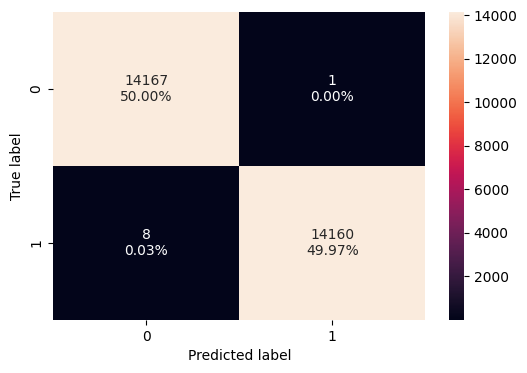

In [83]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_rf2, X_train_over, y_train_over)

In [84]:
# Calculating different metrics on validation set
tuned_rf2_val_perf = model_performance_classification_sklearn(tuned_rf2, X_val, y_val)
tuned_rf2_val_perf

,Accuracy,Recall,Precision,F1
0,0.99,0.86,0.92,0.89


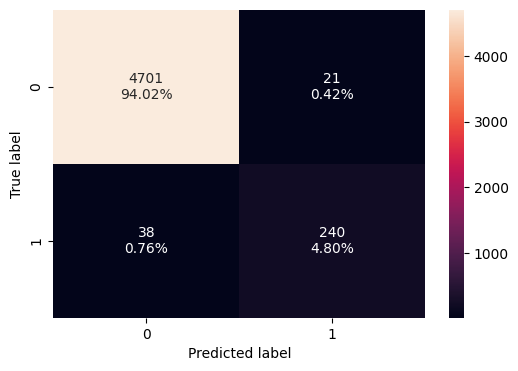

In [85]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_rf2, X_val, y_val)

#### Comments on hyperparameter tuning Random Forest Classifier model with Oversampled data

- Model performs very well on the validation set with very high performance metrics

- However the model appears to be slightly overfit with near perfect training scores but slightly lower scores on the validation set (Training recall is ~1; Validation recall is 0.87)

- Model generalizes reasonably well but not great

- Model performance is similar to pre-tuned random forest model with oversampled data

### 9. Hyperparameter tuning Random Forest Classifer with undersampled data

In [86]:

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.8978140105331505:
CPU times: user 1.94 s, sys: 50.7 ms, total: 1.99 s
Wall time: 40.2 s


In [87]:
# Creating new pipeline with best parameters
tuned_rf3 = RandomForestClassifier(random_state=1, n_estimators = 200, min_samples_leaf = 2, max_samples = 0.4, max_features = 'sqrt')

tuned_rf3.fit(X_train_under,y_train_under)

RandomForestClassifier(max_samples=0.4, min_samples_leaf=2, n_estimators=200,
                       random_state=1)

In [88]:
# Calculating different metrics on train set
tuned_rf3_train_perf = model_performance_classification_sklearn(tuned_rf3, X_train_under, y_train_under)
tuned_rf3_train_perf

,Accuracy,Recall,Precision,F1
0,0.96,0.92,0.99,0.95


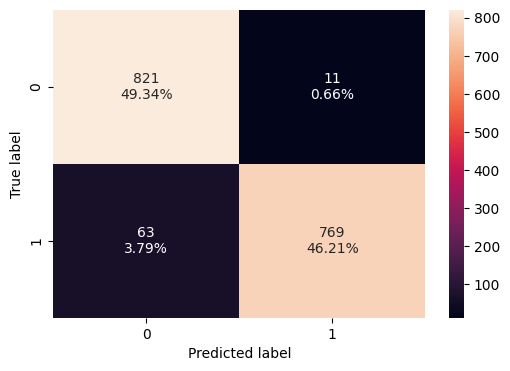

In [89]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_rf3, X_train_under, y_train_under)

In [90]:
# Calculating different metrics on validation set
tuned_rf3_val_perf = model_performance_classification_sklearn(tuned_rf3, X_val, y_val)
tuned_rf3_val_perf

,Accuracy,Recall,Precision,F1
0,0.94,0.88,0.46,0.60


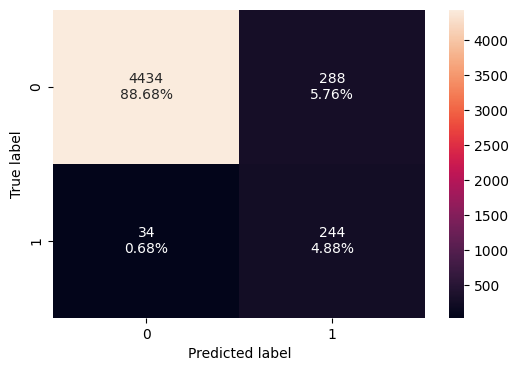

In [91]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_rf3, X_val, y_val)

#### Comments on hyperparameter tuning Random Forest Classifier model with Undersampled data

- Model performs very well on the validation set with respect to accuracy and recall and appears to generalize with respect to these metrics as well

- Model appears to be quite overfit with respect to precision and F1 score and does not generalize


### 10. Hyperparameter tuning Gradient Boosting Classifer with original data

In [92]:

# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}
#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.754895029218671:
CPU times: user 14.6 s, sys: 465 ms, total: 15.1 s
Wall time: 5min 34s


In [93]:
# Creating new pipeline with best parameters
tuned_gb1 = GradientBoostingClassifier(random_state=1, subsample = 0.7, n_estimators = 125, max_features = 0.5, learning_rate = 0.2)

tuned_gb1.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [94]:
# Calculating different metrics on train set
tuned_gb1_train_perf = model_performance_classification_sklearn(tuned_gb1, X_train, y_train)
tuned_gb1_train_perf

,Accuracy,Recall,Precision,F1
0,0.99,0.91,0.99,0.94


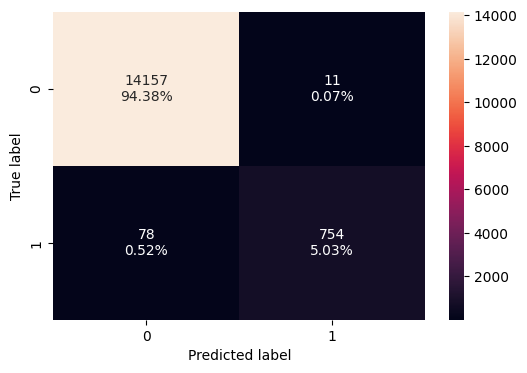

In [95]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_gb1, X_train, y_train)

In [96]:
# Calculating different metrics on validation set
tuned_gb1_val_perf = model_performance_classification_sklearn(tuned_gb1, X_val, y_val)
tuned_gb1_val_perf

,Accuracy,Recall,Precision,F1
0,0.98,0.77,0.89,0.82


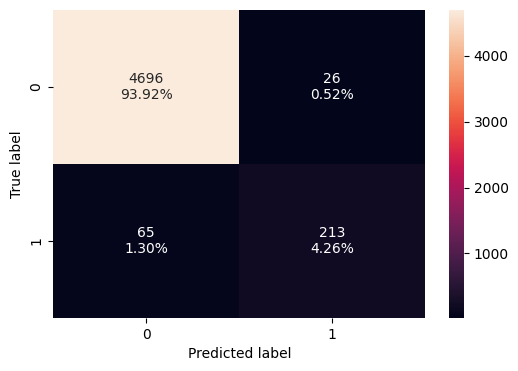

In [97]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_gb1, X_val, y_val)

#### Comments on hyperparameter tuning Gradient Boosting Classifier model with Original data

- Model has a decent but not great recall score on validation set (0.75)

- Model appears to be slightly overfit with respect to recall and F1 score and generalizes reasonably well but not great.

- Model has very high accuracy and precision on validation set and generalizes well with respect to these metrics

### 11. Hyperparameter tuning Gradient Boosting Classifer with oversampled data

In [98]:

# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9723322092856124:
CPU times: user 27.7 s, sys: 941 ms, total: 28.6 s
Wall time: 10min 52s


In [99]:
# Creating new pipeline with best parameters
tuned_gb2 = GradientBoostingClassifier(random_state=1, subsample = 0.7, n_estimators = 125, max_features = 0.5, learning_rate = 1)

tuned_gb2.fit(X_train_over,y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [100]:
# Calculating different metrics on train set
tuned_gb2_train_perf = model_performance_classification_sklearn(tuned_gb2, X_train_over, y_train_over)
tuned_gb2_train_perf

,Accuracy,Recall,Precision,F1
0,0.99,0.99,0.99,0.99


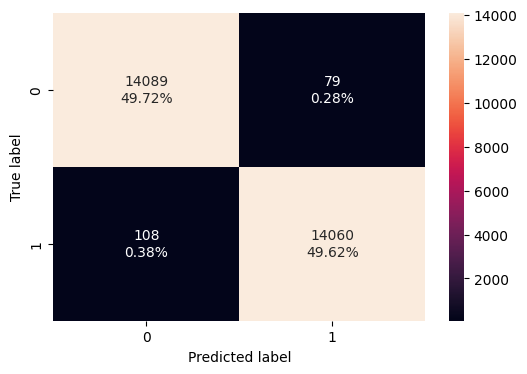

In [101]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_gb2, X_train_over, y_train_over)

In [102]:
# Calculating different metrics on validation set
tuned_gb2_val_perf = model_performance_classification_sklearn(tuned_gb2, X_val, y_val)
tuned_gb2_val_perf

,Accuracy,Recall,Precision,F1
0,0.97,0.86,0.68,0.76


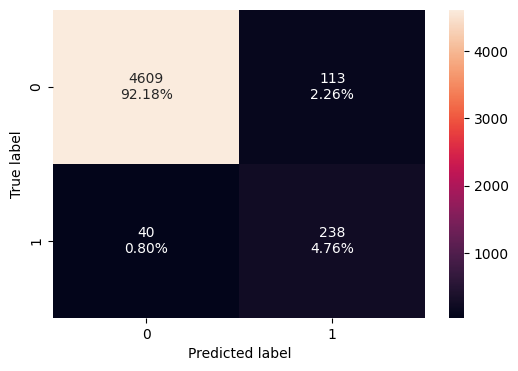

In [103]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_gb2, X_val, y_val)

#### Comments on hyperparameter tuning Gradient Boosting Classifier model with Oversampled data

- Model has high accuracy and recall but pays the price in precision and F1 score on the validation set

- Model appears overfitting particularly in respect to precision and F1 score but should generalize reasonably well with respect to recall and accuracy

### 12. Hyperparameter tuning Gradient Boosting Classifer with undersampled data

In [104]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.9014212538777866:
CPU times: user 1.58 s, sys: 71 ms, total: 1.65 s
Wall time: 48.1 s


In [105]:
# Creating new pipeline with best parameters
tuned_gb3 = GradientBoostingClassifier(random_state=1, subsample = 0.5, n_estimators = 125, max_features = 0.5, learning_rate = 0.2)

tuned_gb3.fit(X_train_under,y_train_under)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.5)

In [106]:
# Calculating different metrics on train set
tuned_gb3_train_perf = model_performance_classification_sklearn(tuned_gb3, X_train_under, y_train_under)
tuned_gb3_train_perf

,Accuracy,Recall,Precision,F1
0,0.99,0.98,1.00,0.99


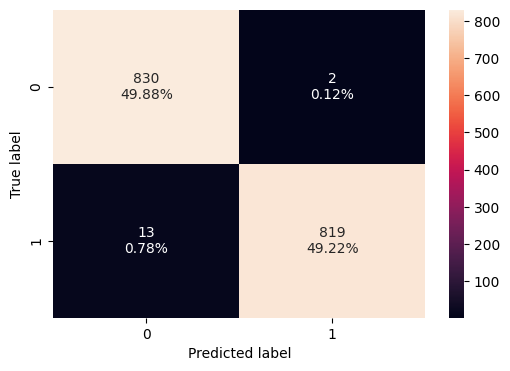

In [107]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_gb3, X_train_under, y_train_under)

In [108]:
# Calculating different metrics on validation set
tuned_gb3_val_perf = model_performance_classification_sklearn(tuned_gb3, X_val, y_val)
tuned_gb3_val_perf

,Accuracy,Recall,Precision,F1
0,0.92,0.88,0.40,0.55


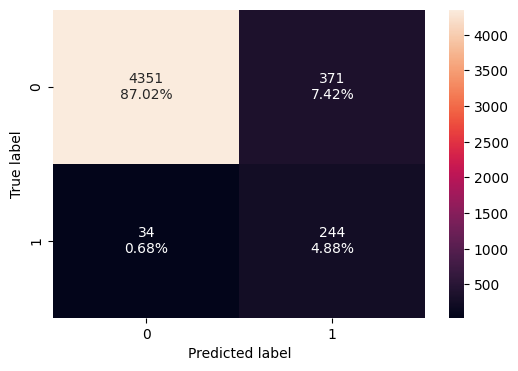

In [109]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_gb3, X_val, y_val)

#### Comments on hyperparameter tuning Gradient Boosting Classifier model with Undersampled data

- Model has high accuracy and recall but pays the price in precision and F1 score on the validation set

- Model appears very overfit in respect to precision and F1 score but should generalize reasonably well with respect to recall and accuracy

### 13. Hyperparameter tuning XGBoost Classifer with original data

In [110]:
 # defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.8546353076978572:
CPU times: user 6.69 s, sys: 149 ms, total: 6.84 s
Wall time: 1min 25s


In [111]:
# Creating new pipeline with best parameters
tuned_xgb1 = XGBClassifier(random_state=1, subsample = 0.9, scale_pos_weight = 10, n_estimators = 150, learning_rate = 0.2, gamma = 3)

tuned_xgb1.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [112]:
# Calculating different metrics on train set
tuned_xgb1_train_perf = model_performance_classification_sklearn(tuned_xgb1, X_train, y_train)
tuned_xgb1_train_perf

,Accuracy,Recall,Precision,F1
0,1.00,1.00,0.98,0.99


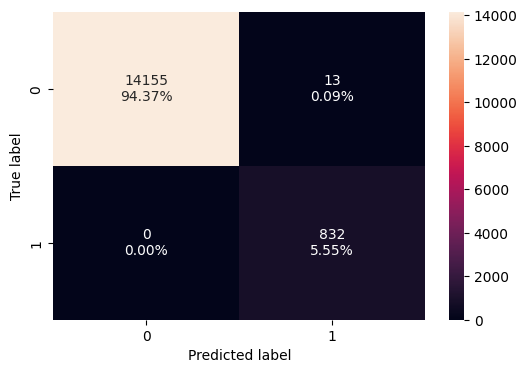

In [113]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_xgb1, X_train, y_train)

In [114]:
# Calculating different metrics on validation set
tuned_xgb1_val_perf = model_performance_classification_sklearn(tuned_xgb1, X_val, y_val)
tuned_xgb1_val_perf

,Accuracy,Recall,Precision,F1
0,0.99,0.85,0.95,0.90


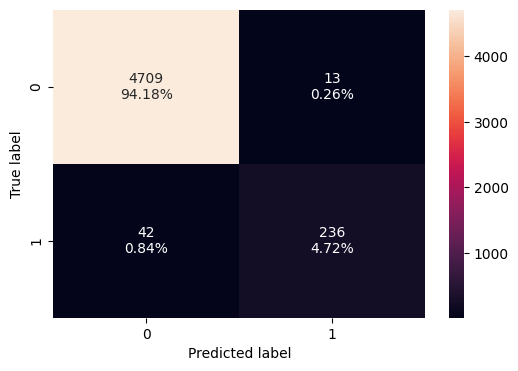

In [115]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_xgb1, X_val, y_val)

#### Comments on hyperparameter tuning XGBoost Classifier model with Original data

- Model performs really well with most performance metrics with validation recall score of 0.88

- Model also generalizes quite well with most metrics particulary accuracy and precision

- Model recall is significantly improved from the non-tuned XG Boost model using original data



### 14. Hyperparameter tuning XGBoost Classifer with oversampled data

In [116]:
 # defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9959769935987322:
CPU times: user 7.34 s, sys: 224 ms, total: 7.56 s
Wall time: 2min 22s


In [117]:
# Creating new pipeline with best parameters
tuned_xgb2 = XGBClassifier(random_state=1, subsample = 0.9, scale_pos_weight = 10, n_estimators = 200, learning_rate = 0.2, gamma = 0)

tuned_xgb2.fit(X_train_over,y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [118]:
# Calculating different metrics on train set
tuned_xgb2_train_perf = model_performance_classification_sklearn(tuned_xgb2, X_train_over, y_train_over)
tuned_xgb2_train_perf

,Accuracy,Recall,Precision,F1
0,1.00,1.00,1.00,1.00


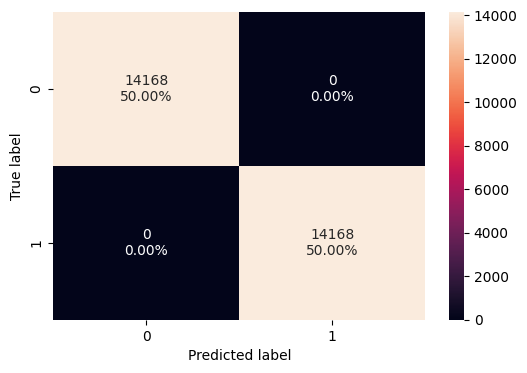

In [119]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_xgb2, X_train_over, y_train_over)

In [120]:
# Calculating different metrics on validation set
tuned_xgb2_val_perf = model_performance_classification_sklearn(tuned_xgb2, X_val, y_val)
tuned_xgb2_val_perf

,Accuracy,Recall,Precision,F1
0,0.98,0.87,0.86,0.86


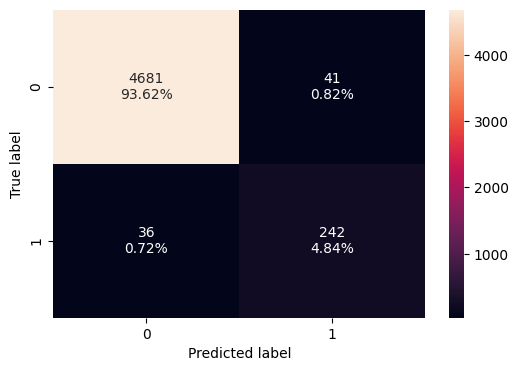

In [121]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_xgb2, X_val, y_val)

#### Comments on hyperparameter tuning XGBoost Classifier model with Oversampled data

- Model performs really well with respect to recall in validation set (0.92)

- Model shows decent generalization with respect to accuracy and recall

- Model appears to be very overfit with respect to precision and F1 score

- Model recall score on the validation set is improved from the non-tuned XGB model with oversampled data

### 15. Hyperparameter tuning XGBoost Classifer with undersampled data

In [122]:
# defining model
Model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under,y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9290599523843879:
CPU times: user 2.01 s, sys: 82.1 ms, total: 2.09 s
Wall time: 47.4 s


In [123]:
# Creating new pipeline with best parameters
tuned_xgb3 = XGBClassifier(random_state=1, subsample = 0.8, scale_pos_weight = 10, n_estimators = 150, learning_rate = 0.1, gamma = 3)

tuned_xgb3.fit(X_train_under,y_train_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [124]:
# Calculating different metrics on train set
tuned_xgb3_train_perf = model_performance_classification_sklearn(tuned_xgb3, X_train_under, y_train_under)
tuned_xgb3_train_perf

,Accuracy,Recall,Precision,F1
0,0.99,1.00,0.98,0.99


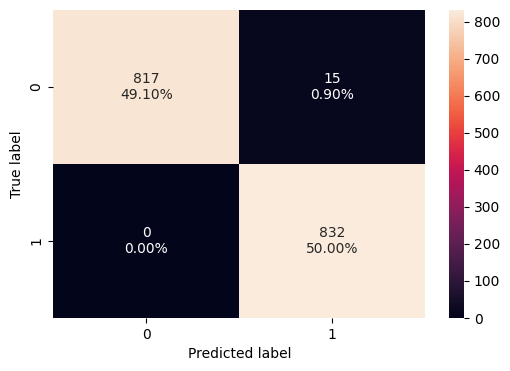

In [125]:
#Confusion matrix on train set
confusion_matrix_sklearn(tuned_xgb3, X_train_under, y_train_under)

In [126]:
# Calculating different metrics on validation set
tuned_xgb3_val_perf = model_performance_classification_sklearn(tuned_xgb3, X_val, y_val)
tuned_xgb3_val_perf

,Accuracy,Recall,Precision,F1
0,0.86,0.92,0.28,0.43


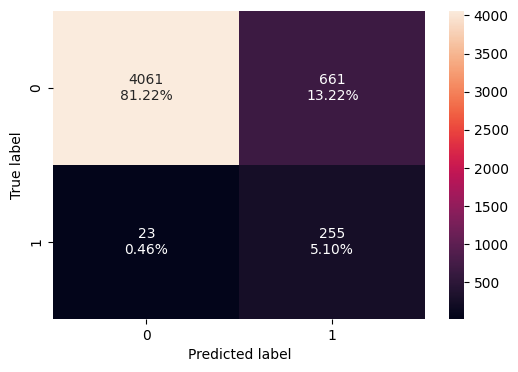

In [127]:
#Confusion matrix on validation set
confusion_matrix_sklearn(tuned_xgb3, X_val, y_val)

#### Comments on hyperparameter tuning XGBoost Classifier model with Undersampled data

- Model performs really well with respect to recall in validation set (0.94)

- Model shows decent generalization with respect to recall score in validation set

- Model appears to be extremely overfit with respect to precision and F1 score and overfit with respect to accuracy

- Model recall score on the validation set is improved from the non-tuned XGB model with oversampled data


## Model performance comparison and choosing the final model

In [128]:
# Model Name as Index
index = pd.Index(
    [
        "Log_Reg_Tuned",
        "Log_Reg_Tuned_Over",
        "Log_Reg_Tuned_Under",
        "Decision_Tree_Tuned",
        "Decision_Tree_Tuned_Over",
        "Decision_Tree_Tuned_Under",
        "Random_Forest_Tuned",
        "Random_Forest_Tuned_Over",
        "Random_Forest_Tuned_Under",
        "Gradient_Boost_Tuned",
        "Gradient_Boost_Tuned_Over",
        "Gradient_Boost_Tuned_Under",
        "XGBoost_Tuned",
        "XGBoost_Tuned_Over",
        "XGBoost_Tuned_Under",

    ]
)

# Create DataFrame with different models as rows, and performance metrics as columns
model_train_perf_comp = pd.concat(
    [
        tuned_lr1_train_perf,
        tuned_lr2_train_perf,
        tuned_lr3_train_perf,
        tuned_dt1_train_perf,
        tuned_dt2_train_perf,
        tuned_dt3_train_perf,
        tuned_rf1_train_perf,
        tuned_rf2_train_perf,
        tuned_rf3_train_perf,
        tuned_gb1_train_perf,
        tuned_gb2_train_perf,
        tuned_gb3_train_perf,
        tuned_xgb1_train_perf,
        tuned_xgb2_train_perf,
        tuned_xgb3_train_perf,

    ],
    ignore_index=True,
)

# set model names as index
model_train_perf_comp = model_train_perf_comp.set_index(index)

print('*'*50)
print("Training Performance Comparison between models")
print('*'*50)
print("\n ")
print("-"*100)
model_train_perf_comp

**************************************************
Training Performance Comparison between models
**************************************************

 
----------------------------------------------------------------------------------------------------


,Accuracy,Recall,Precision,F1
Log_Reg_Tuned,0.97,0.50,0.85,0.62
Log_Reg_Tuned_Over,0.88,0.88,0.88,0.88
Log_Reg_Tuned_Under,0.87,0.88,0.87,0.87
Decision_Tree_Tuned,0.97,0.59,0.90,0.72
Decision_Tree_Tuned_Over,0.90,0.89,0.90,0.90
Decision_Tree_Tuned_Under,0.91,0.88,0.95,0.91
Random_Forest_Tuned,1.00,0.91,1.00,0.95
Random_Forest_Tuned_Over,1.00,1.00,1.00,1.00
Random_Forest_Tuned_Under,0.96,0.92,0.99,0.95
Gradient_Boost_Tuned,0.99,0.91,0.99,0.94


### Validation Performance Comparison

In [129]:
# Model Name as Index
index = pd.Index(
    [
        "Log_Reg_Tuned",
        "Log_Reg_Tuned_Over",
        "Log_Reg_Tuned_Under",
        "Decision_Tree_Tuned",
        "Decision_Tree_Tuned_Over",
        "Decision_Tree_Tuned_Under",
        "Random_Forest_Tuned",
        "Random_Forest_Tuned_Over",
        "Random_Forest_Tuned_Under",
        "Gradient_Boost_Tuned",
        "Gradient_Boost_Tuned_Over",
        "Gradient_Boost_Tuned_Under",
        "XGBoost_Tuned",
        "XGBoost_Tuned_Over",
        "XGBoost_Tuned_Under",

    ]
)

# Create DataFrame with different models as rows, and performance metrics as columns
model_val_perf_comp = pd.concat(
    [
        tuned_lr1_val_perf,
        tuned_lr2_val_perf,
        tuned_lr3_val_perf,
        tuned_dt1_val_perf,
        tuned_dt2_val_perf,
        tuned_dt3_val_perf,
        tuned_rf1_val_perf,
        tuned_rf2_val_perf,
        tuned_rf3_val_perf,
        tuned_gb1_val_perf,
        tuned_gb2_val_perf,
        tuned_gb3_val_perf,
        tuned_xgb1_val_perf,
        tuned_xgb2_val_perf,
        tuned_xgb3_val_perf,

    ],
    ignore_index=True,
)

# set model names as index
model_val_perf_comp = model_val_perf_comp.set_index(index)

print('*'*50)
print("Validation Performance Comparison between models")
print('*'*50)
print("\n")
print("-"*100)
model_val_perf_comp

**************************************************
Validation Performance Comparison between models
**************************************************


----------------------------------------------------------------------------------------------------


,Accuracy,Recall,Precision,F1
Log_Reg_Tuned,0.97,0.48,0.84,0.61
Log_Reg_Tuned_Over,0.87,0.85,0.28,0.42
Log_Reg_Tuned_Under,0.86,0.85,0.26,0.40
Decision_Tree_Tuned,0.97,0.58,0.82,0.68
Decision_Tree_Tuned_Over,0.89,0.86,0.32,0.47
Decision_Tree_Tuned_Under,0.90,0.85,0.34,0.48
Random_Forest_Tuned,0.98,0.71,0.99,0.83
Random_Forest_Tuned_Over,0.99,0.86,0.92,0.89
Random_Forest_Tuned_Under,0.94,0.88,0.46,0.60
Gradient_Boost_Tuned,0.98,0.77,0.89,0.82


## Summary of Performances of all tuned Models

- Most of the models **performs really well** in terms of **accuracy metric** (~ > 0.9 in most models)

- Most of the models also **generalize** quite well in terms of **data accuracy**

- In terms of recall, most of the models **using oversampled and undersampled data** outperforms the models using **original data**

- This isn't suprising given that these sampling techniques help improve the predictive power of the model on the minority class - **Class 1**

- Most of the models also **generalize relatively well** in terms of **recall metric**

- Most of the models using original data seem to generalize much better in terms of **precision and F1 score** compared to models using oversampled and undersampled data

- Most of the models using oversampled and undersampled data seem to be overfit in terms of **precision and F1 score**

- This is likely partly due to the emphasis on using recall as a scorer during cross validation which forces the models to correctly predict the minority class sometimes at the cost of incorrectly predicting the majority class when using over- and undersampling

- All of the 3 XGBoost Classifier model performs the best in terms of recall in the validation set data but the oversampling and undersampling models do not generalize very well in terms of F1 score and precision

- Top 2 models from all the tuned models that perform reasonably well on most metrics as well as generalizes are
  - Tuned Random Forest Classifier using Oversampled data
  - Tuned XGBoost Classifier using oversampled data

## Final Model Selection

- In terms of selecting the final model to be sent for production, emphasis was given in choosing a model that had the following attributes
  - Model performs quite well in terms of recall as the largest priority is to predict the minority class accurately
  - Model generalizes quite well and do not suffer from overfitting in terms of recall so that model in production will perform well with unseen data
  - Model generalizes reasonably well in terms of other metrics such as precision and F1 score so that the model does not perform poorly with unseen data on those metrics and have fewer incorrect predictions

- Top 2 models from all the tuned models that meet the aforementioned criteria were the following
  - (1) Tuned Random Forest Classifier using Oversampled data
  - (2) Tuned XGBoost Classifier

- XGBoost Classifier is chosen as the final model because of the following reasons:
  - It has slightly higher recall score compared to the other model
  - It generalizes slightly better in terms of recall with the other top model
  - It generalizes better in terms of accuracy, precision and F1 score relative to the other top model

### Test set final performance

In [153]:
# Calculating different metrics on the test set
model_test = model_performance_classification_sklearn(tuned_xgb1, X_test, y_test)
print("Test Peformance")
model_test

Test Peformance


,Accuracy,Recall,Precision,F1
0,0.99,0.84,0.95,0.89


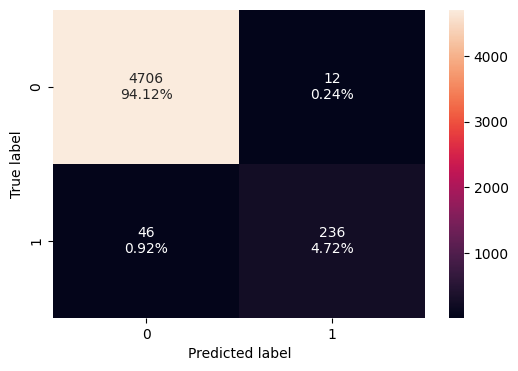

In [154]:
#Confusion matrix on the test set
confusion_matrix_sklearn(tuned_xgb1, X_test, y_test)

Observations:

- Final model has a accuracy of **0.99** on test data

- Final model has a recall score of **0.84** on test data

- Final model has both the precision of **0.95** and F1 score of **0.89** on test data

- Final model performs quite well with unseen test data

- Final model generalizes quite well with unseen test data

### Feature Importances

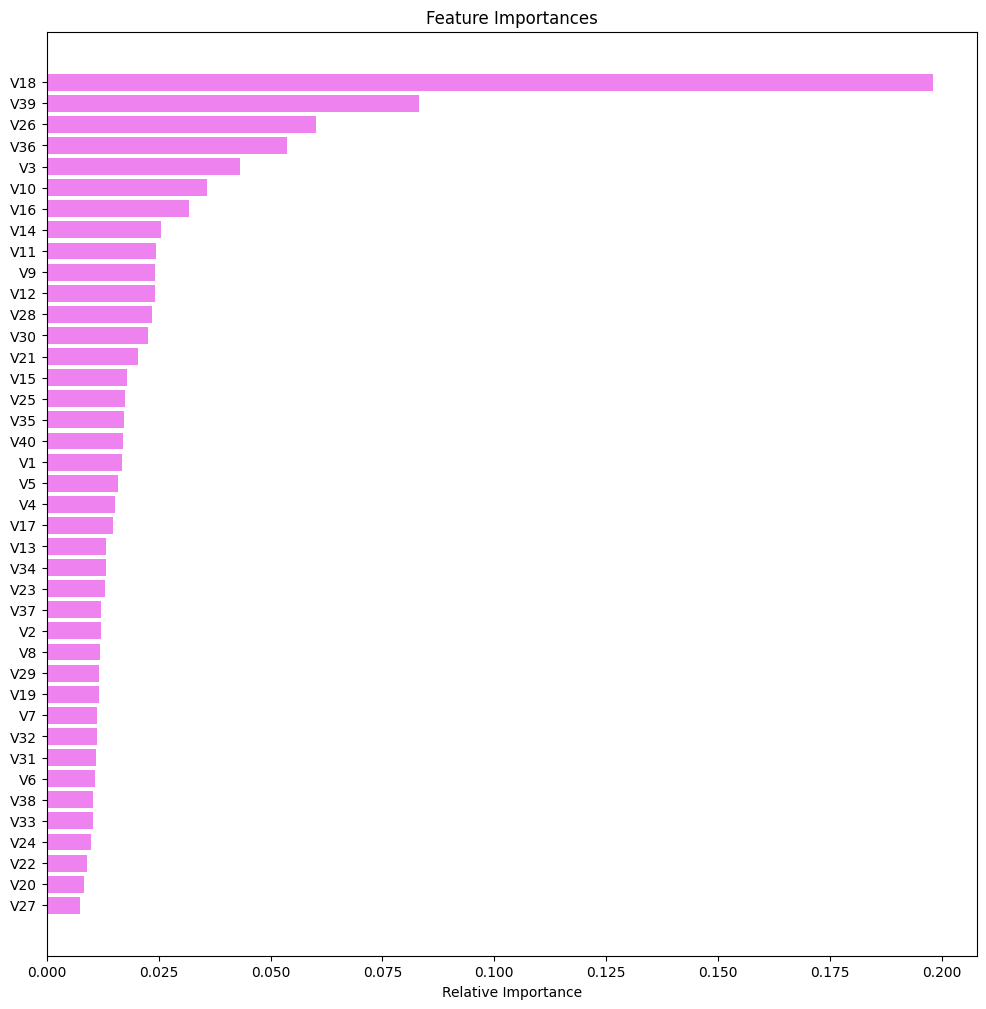

In [155]:
feature_names = X_train.columns
importances = tuned_xgb1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [156]:
# calculate the cost without the model
act_cost_without = 40000*len(y_test[y_test==1])
print("The actual cost to ReneWind without the model would have been $"+"{:,}".format(act_cost_without))

The actual cost to ReneWind without the model would have been $11,280,000


In [158]:
# calculate the actual cost using the above confusion matrix from the XGBoost model
act_cost_with = 40000*46+(5000+15000)*236+5000*12
print("The actual cost for ReneWind after implementing the preventative maintenance model would have been $"
      +"{:,}".format(act_cost_with))

The actual cost for ReneWind after implementing the preventative maintenance model would have been $6,620,000


## Pipelines to build the final model


In [143]:
# Build a pipeline with simple imputer to impute missing values and use the final model for production
Model = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "XGB_Tuned",
            XGBClassifier(random_state=1,
                          subsample = 0.9,
                          scale_pos_weight = 10,
                          n_estimators = 150,
                          learning_rate = 0.2,
                          gamma = 3
            ),
        ),
    ]
)

In [145]:
# Separating target variable and other variables
X1 = df_train.drop(columns="Target")
Y1 = df_train["Target"]

# Since we already have a separate test set, we don't need to divide data into train and test

X_test1 = df_test.drop(["Target"], axis=1)
y_test1 = df_test["Target"]



In [159]:
# Treating missing values in train set
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# Treating missing values in the test set
X2 = imputer.transform(X_test1)

In [160]:
# Fit the productionized model
Model.fit(X1, Y1)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGB_Tuned',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [161]:
# Make predictions on the test data using the productionized model
Model.predict(X2)

array([0, 0, 0, ..., 0, 0, 0])

## Conclusion

* **Objective:**
  * The goal was to predict generator failures in wind turbines before they occur, minimizing maintenance costs.
  * **Key Insight:** The replacement cost (when no failure is predicted but one occurs) is **2X** the combined cost of repair and inspection (for correct failure predictions).
  
* **Machine Learning Models Used:**
  * A total of **7 classifier models** were tested:
    * **Logistic Regression**
    * **Decision Tree**
    * **Bagging Classifier**
    * **Random Forest Classifier**
    * **Gradient Boosting Classifier**
    * **AdaBoost Classifier**
    * **XGBoost Classifier**

* **Data Imbalance:**
  * The dataset was highly imbalanced, with the failure class (Class 1) accounting for only **5%** of the data.
  * **Techniques Used:**
    * **Oversampling** and **undersampling** were applied to address the imbalance and improve the model’s performance on the minority class (failure predictions).

* **Hyperparameter Tuning:**
  * Tuning was performed on the models to enhance performance and reduce overfitting/underfitting.

* **Top Performing Models:**
  * Based on recall score and model generalization on unseen data, the following two models emerged as top contenders:
    * **Tuned Random Forest Classifier** using oversampled data.
    * **Tuned XGBoost Classifier** using original data.
  
  * **Final Model Chosen:**  
    * The **XGBoost Classifier using original data** was selected as the final model due to its better overall performance.

* **Model Performance:**
 * Final model has a accuracy of 0.99 on test data
 * Final model has a recall score of 0.84 on test data
 * Final model has both the precision of 0.95 and F1 score of 0.89 on test data

* **Important Sensors:**
  * The final model identified **Sensor V18** as the most important for predicting generator failure.
  * The next most important sensors (in order) were **V36**, **V26**, and **V39**.

This approach helped Renewind accurately predict generator failures while maintaining high model performance on unseen data.


**Business Insights:**
* Sensor V18 is critical for predicting impending generator failure.
* Other sensors such as V36, V26, and V39 also provide valuable data, but to a lesser extent.
* Focus closely on data from V18 and possibly V36, V26, and V39 to detect potential generator failures early.
* If data suggests a potential failure, send a technician for inspection and repairs if necessary.

**Alternative Approach to ML Model Evaluation:**
* Current ML models use recall score to predict generator failure, but an alternative metric could be used: total service cost.
* Total service cost can be calculated using the confusion matrix:
- True Positive (TP): Cost of accurately predicting failure (inspection + repair).
- True Negative (TN): Cost of accurately predicting no failure (no cost).
- False Positive (FP): Cost of incorrectly predicting failure (inspection only, no repair).
- False Negative (FN): Cost of missing a failure (replacement cost).

The goal would be to minimize total service cost, potentially leading to more cost-effective maintenance for Renewind.

**Improving Model Performance:**

* Renewind should decide whether further improving recall score is critical for their needs.
* If improving generalization with unseen data is a priority, consider using GridSearchCV (more time-intensive) instead of RandomizedSearchCV, along with a wider range of hyperparameters to enhance model performance.

**Expanding Data for Better Models:**

* Seek additional data from existing or new sensors to create a larger, more diverse dataset.
* A more comprehensive dataset could lead to a more generalizable and accurate predictive model.

This approach could help Renewind reduce long-term maintenance costs while improving prediction accuracy for generator failures.